# Banking and Marketing UCI

The dataset is from https://archive.ics.uci.edu/ml/datasets/bank+marketing.
The description is following,
 ### Input variables:
   #### bank client data:
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")  
   3 - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")  
   5 - default: has credit in default? (categorical: "no","yes","unknown")  
   6 - housing: has housing loan? (categorical: "no","yes","unknown")  
   7 - loan: has personal loan? (categorical: "no","yes","unknown")  
   #### related with the last contact of the current campaign:
   8 - contact: contact communication type (categorical: "cellular","telephone")   
   9 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  10 - day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")  
  11 - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
   #### other attributes:
  12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)  
  14 - previous: number of contacts performed before this campaign and for this client (numeric)  
  15 - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")  
   #### social and economic context attributes
  16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)  
  17 - cons.price.idx: consumer price index - monthly indicator (numeric)     
  18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)       
  19 - euribor3m: euribor 3 month rate - daily indicator (numeric)  
  20 - nr.employed: number of employees - quarterly indicator (numeric)  

  ### Output variable (desired target):
  21 - y - has the client subscribed a term deposit? (binary: "yes","no")

## Explore data

In [180]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read data
df = pd.read_csv('bank-additional-full.csv', sep = ';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

The dataset contains 20 parameters and 1 label. `y` is the label, which are `yes` and `no`. The labels need to change to 1 or 0 in the future.

The 20 parameters 10 numerical variables and 10 categorical variables. Luckily, there is no null value from the first glance. 

The numerical variables need to be explored the distribution, check the outliers, and the relation with the output(`y`).

- `age`: check distribution, relation to output.
- `duration`: can be explored, but it seems to have strong relation to the outcome, and need to be excluded.
- `campaign`, `pdays`, `previous`: find the relation to the outcome
- `emp.var.rate`, `cons.price.idx`, `con.conf.idx`, `euribor3m`, `nr.employed`: find relation to outcome.

The categorical variables need to be labelencoded or onehot coded before modeling, but can be explored.


In [4]:
# make a copy before make any change
df_exp = df.copy()

Notice `unknow` is acturally the missing value.

In [5]:
df_exp = df_exp.replace('unknown', np.nan)

### Explore each single variable and clean them

Numerical variables first, and then categorical.

### `age`

In [6]:
df_exp['age'].describe()

count    41188.00000
mean        40.02406
std         10.42125
min         17.00000
25%         32.00000
50%         38.00000
75%         47.00000
max         98.00000
Name: age, dtype: float64

Histogram plot

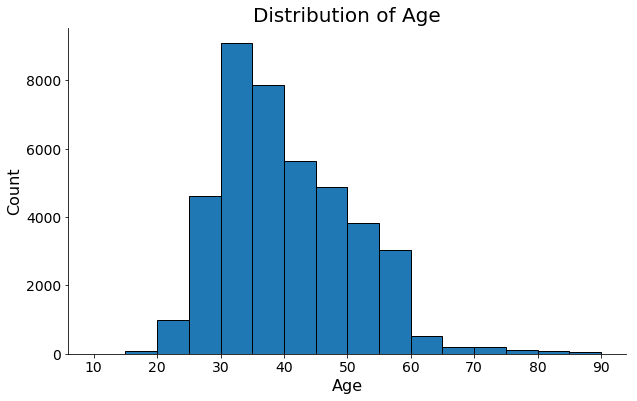

In [7]:
fig, ax = plt.subplots(figsize = (10,6))
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
plt.title('Distribution of Age', fontdict = {'fontsize': 20,
                                             'fontweight': 500})
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.xlabel("Age", fontsize=16)  
plt.ylabel("Count", fontsize=16)
plt.hist(df_exp['age'], edgecolor='black', bins = range(10,95,5));

Most of examples are around 30 or 40 years old. There is no obvious outliers.

To reduce the redundancy, define a function to make the histogram plot for numerical variable in the future.

In [8]:
def histplot(name,in_df = df_exp, returncontrol = False, bins = None):
    fig, ax = plt.subplots(figsize = (10,6))
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    plt.title('Distribution of ' + name, 
              fontdict = {'fontsize': 20,
                          'fontweight': 500})
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)
    plt.xlabel(name, fontsize=16)  
    plt.ylabel("Count", fontsize=16)
    plt.hist(in_df[name], edgecolor='black', bins = bins);
    if returncontrol: return fig

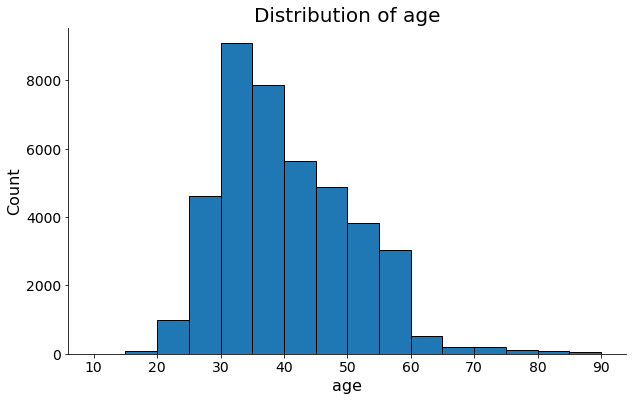

In [9]:
histplot('age', bins = range(10,95,5))

The relation to the outcome. Also define a function to make the plot.

In [10]:
def yviolplot(name, in_df = df_exp, returncontrol = False, col = None, ylim = None):
    fig, ax = plt.subplots(figsize = (10,6))
    sns.set_style('whitegrid')
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    plt.title(name + ' distribution on y', 
              fontdict = {'fontsize': 20,
                          'fontweight': 500})
    plt.xticks(fontsize=14) 
    plt.yticks(fontsize=14)
    if ylim is not None: plt.ylim(ylim)
    plt.xlabel('Y', fontsize=16)  
    plt.ylabel(name, fontsize=16)
    sns.violinplot(x = 'y', y = name, data = in_df, 
                   inner = 'quartile', 
                   palette = ['#78C850',  # Grass
                              '#F08030',  # Fire
                              '#6890F0',  # Water
                              '#A8B820',  # Bug
                              '#A8A878',  # Normal
                              '#A040A0',  # Poison
                              '#F8D030',  # Electric
                              '#E0C068',  # Ground
                              '#EE99AC',  # Fairy
                              '#C03028',  # Fighting
                              '#F85888',  # Psychic
                              '#B8A038',  # Rock
                              '#705898',  # Ghost
                              '#98D8D8',  # Ice
                              '#7038F8',  # Dragon
                             ]);
    if returncontrol: return fig

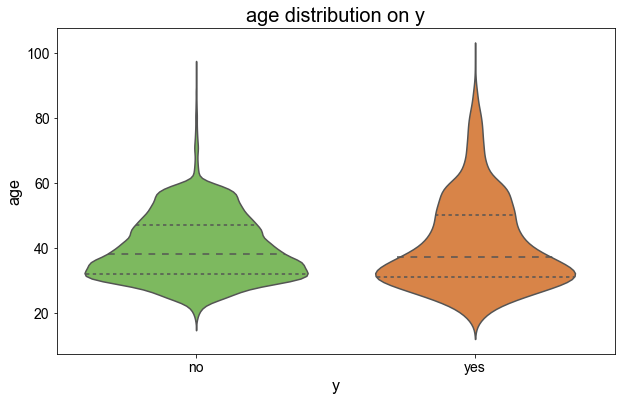

In [11]:
yviolplot('age')

It seems the elder people (age > 60) has more `yes` than others. So does age less than 20. In order to see the detail of the outcome rate, need to make `age` categorical.

In [12]:
cut_range = [0,20] + list(range(30, 80, 10)) + [80, 100]
labels = ['{0} - {1}'.format(cut_range[i], cut_range[i+1]) for i in range(len(cut_range) - 1)]
df_exp['age_group'] = pd.cut(df_exp['age'], cut_range, right = False, labels = labels)

Also make a function to output the plot about the succeed rate.

In [13]:
def ybarplot(name, in_df = df_exp, returncontrol = False, col = None):
    tot_y = sum(in_df['y'] == 'yes')/len(in_df['y'])
    tot = in_df.groupby(name)['y'].count()
    suc = in_df[in_df['y'] == 'yes'].groupby(name)['y'].count()
    plot_col = (suc/tot).sort_values(ascending = False)
    if col is not None:
        plot_col = plot_col.reindex(col)
    plot_col = plot_col.fillna(0)
    print(plot_col)
    out_name = name.replace('_', ' ').capitalize()
    fig, ax = plt.subplots(figsize = (10,6))
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    plt.title('Percentage of subscription on ' + out_name, 
               fontdict = {'fontsize': 20,
                           'fontweight': 500})
    plt.xticks(fontsize=14, rotation=45)  
    plt.yticks(fontsize=14)
    plt.xlabel(out_name, fontsize=16)  
    plt.ylabel("Percentage", fontsize=16)
    plt.bar(plot_col.index, plot_col.values, edgecolor='black');
    plt.axhline(y = tot_y, color = 'red', lw = 1);
    if returncontrol: return fig

age_group
0 - 20      0.453333
20 - 30     0.158742
30 - 40     0.101252
40 - 50     0.079232
50 - 60     0.101574
60 - 70     0.346685
70 - 80     0.451411
80 - 100    0.513333
Name: y, dtype: float64


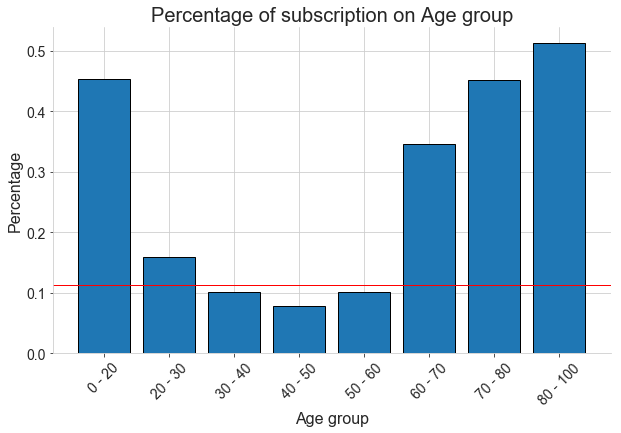

In [14]:
ybarplot('age_group', col = labels)

It is very clear that age larger than 60 and less than 20 are more like to have positive outcome.

### Function defined:

- `histplot`: single variable histogram plot.
- `yviolplot`: numerical variable succeed relation.
- `ybarplot`: categorical variable succeed rate.

### `duration`

In [15]:
df_exp['duration'].describe()

count    41188.000000
mean       258.285010
std        259.279249
min          0.000000
25%        102.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64

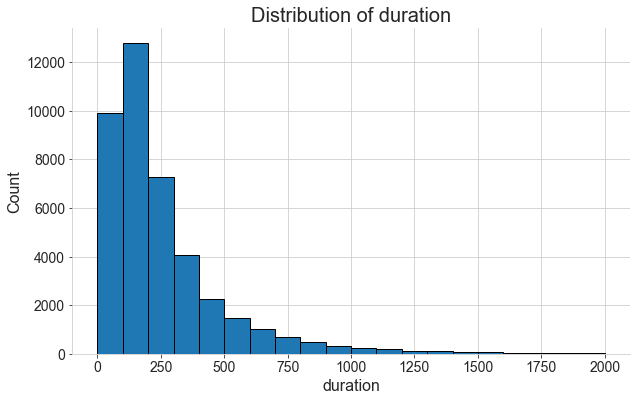

In [16]:
histplot('duration', bins = range(0,2005,100))

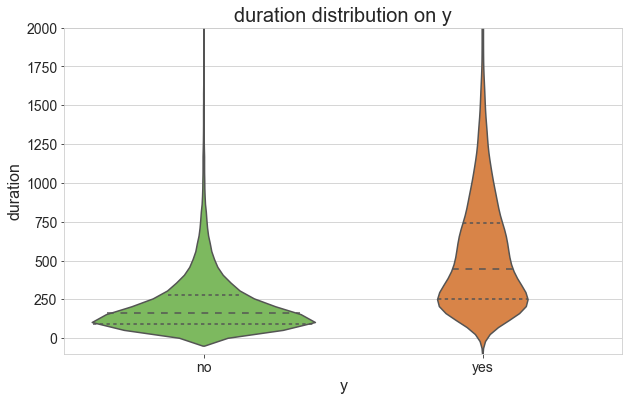

In [17]:
yviolplot('duration', ylim = (-100,2000))

The duration has very strong relation to the outcome. However, in practice, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

### `campaign`

In [18]:
df_exp['campaign'].describe()

count    41188.000000
mean         2.567593
std          2.770014
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: campaign, dtype: float64

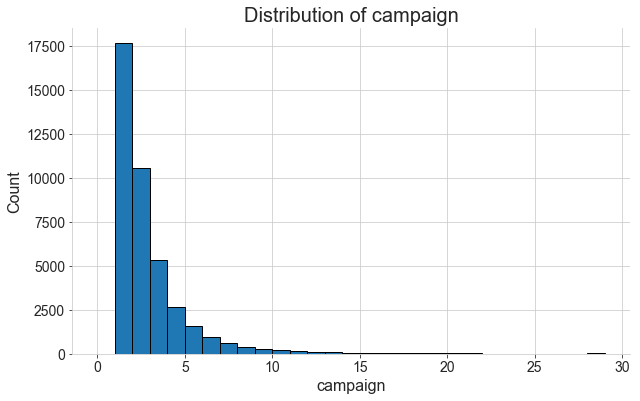

In [19]:
histplot('campaign', bins = range(0, 30, 1))

Very unbalanced.

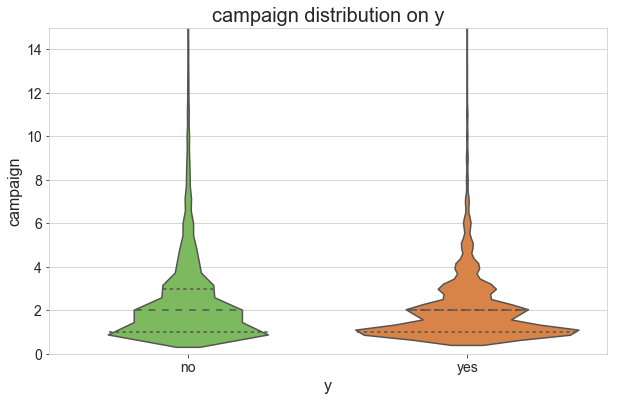

In [20]:
yviolplot('campaign', ylim = (0, 15))

In [21]:
cut_range = list(range(0, 20)) + [20, 60]
labels = ['{0} - {1}'.format(cut_range[i], cut_range[i+1]) for i in range(len(cut_range) - 1)]
df_exp['campaign_group'] = pd.cut(df_exp['campaign'], cut_range, right = False, labels = labels)


campaign_group
0 - 1      0.000000
1 - 2      0.130371
2 - 3      0.114570
3 - 4      0.107471
4 - 5      0.093927
5 - 6      0.075047
6 - 7      0.076609
7 - 8      0.060413
8 - 9      0.042500
9 - 10     0.060071
10 - 11    0.053333
11 - 12    0.067797
12 - 13    0.024000
13 - 14    0.043478
14 - 15    0.014493
15 - 16    0.039216
16 - 17    0.000000
17 - 18    0.068966
18 - 19    0.000000
19 - 20    0.000000
20 - 60    0.005348
Name: y, dtype: float64


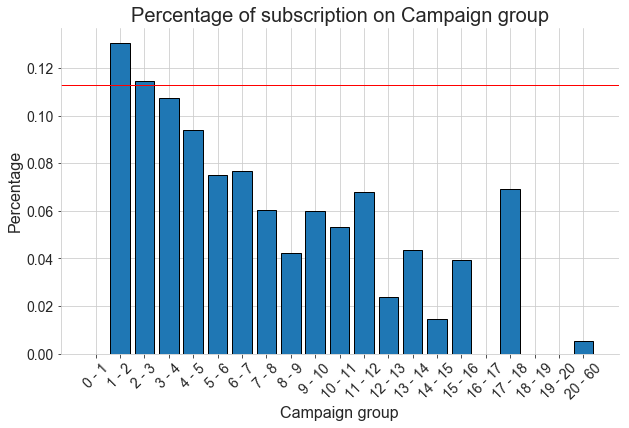

In [22]:
ybarplot('campaign_group', col = labels)

Most of the cases have campaign 1-2 times. They have the succeed rate higher than the total rate, the rest are lower.

### `pdays`

In [23]:
df_exp['pdays'].describe()

count    41188.000000
mean       962.475454
std        186.910907
min          0.000000
25%        999.000000
50%        999.000000
75%        999.000000
max        999.000000
Name: pdays, dtype: float64

Most of the data never been contacted before, this value are 999.

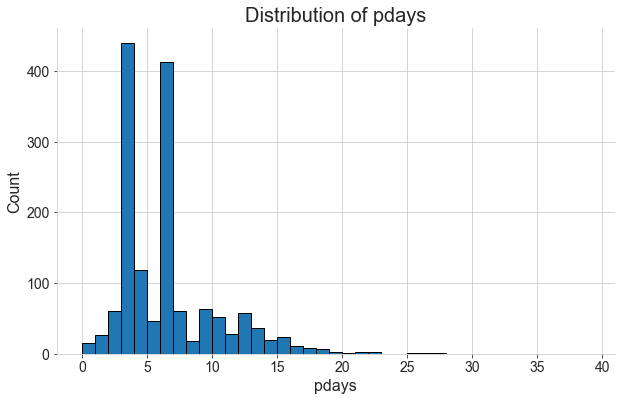

In [24]:
histplot('pdays', bins = range(0,40,1 ))

pdays_group
0 - 2        0.439024
2 - 4        0.670000
4 - 6        0.560976
6 - 8        0.697034
8 - 10       0.573171
10 - 12      0.562500
12 - 14      0.574468
14 - 16      0.613636
16 - 18      0.421053
18 - 20      0.500000
20 - 22      0.666667
22 - 24      0.666667
24 - 26      1.000000
26 - 28      1.000000
28 - 30      0.000000
30 - 1000    0.092582
Name: y, dtype: float64


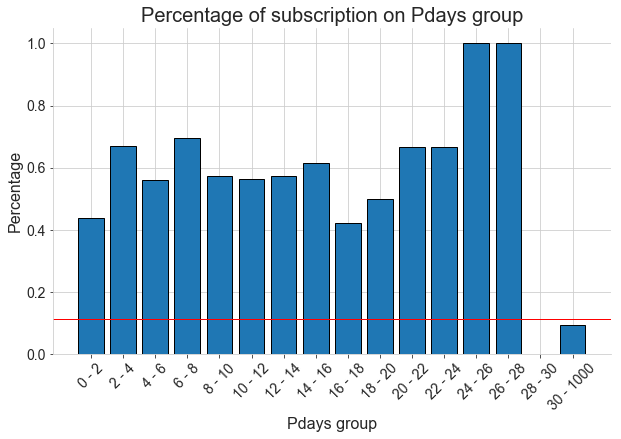

In [25]:
cut_range = list(range(0, 30,2)) + [30, 1000]
labels = ['{0} - {1}'.format(cut_range[i], cut_range[i+1]) for i in range(len(cut_range) - 1)]
df_exp['pdays_group'] = pd.cut(df_exp['pdays'], cut_range, right = False, labels = labels)
ybarplot('pdays_group', col = labels)

The cases that have been contacted before have obviously higher succeed rate than others.

### `previous`

In [26]:
df_exp['previous'].describe()

count    41188.000000
mean         0.172963
std          0.494901
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: previous, dtype: float64

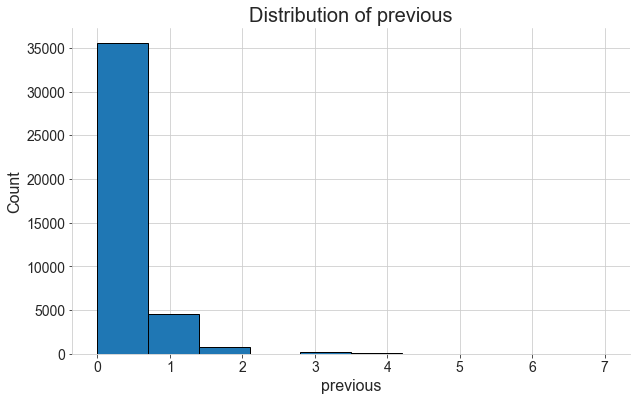

In [27]:
histplot('previous')

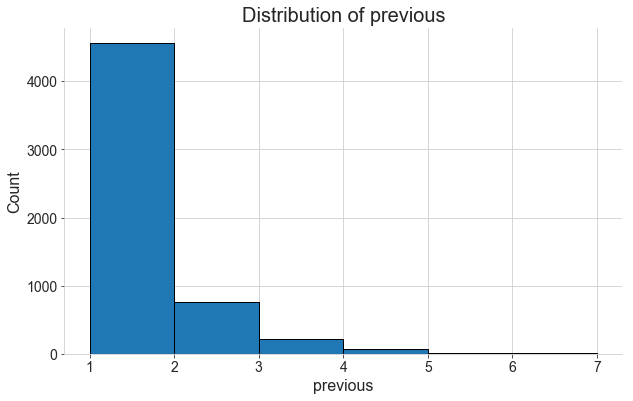

In [28]:
histplot('previous', bins = range(1,8))

previous
5    0.722222
6    0.600000
3    0.592593
4    0.542857
2    0.464191
1    0.212015
0    0.088322
7    0.000000
Name: y, dtype: float64


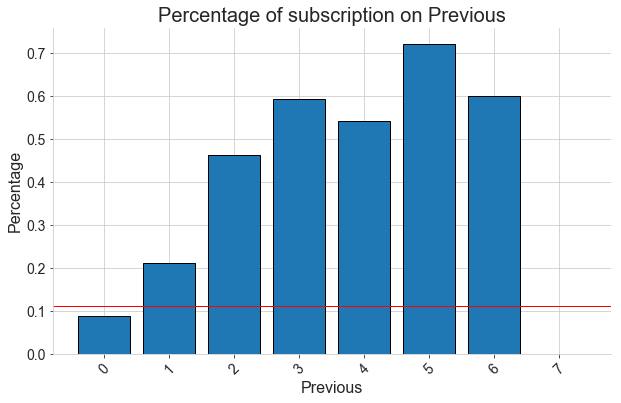

In [29]:
ybarplot('previous')

The more contacts performed, the better outcome in return.

### `emp.var.rate`

In [30]:
df_exp['emp.var.rate'].describe()

count    41188.000000
mean         0.081886
std          1.570960
min         -3.400000
25%         -1.800000
50%          1.100000
75%          1.400000
max          1.400000
Name: emp.var.rate, dtype: float64

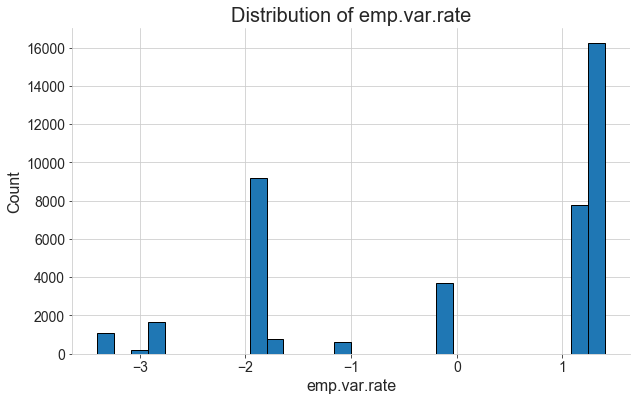

In [31]:
histplot('emp.var.rate', bins = 30)

emp.var.rate
-1.7    0.521345
-3.0    0.511628
-1.1    0.474016
-3.4    0.423903
-2.9    0.357186
-1.8    0.159081
-0.2    0.100000
-0.1    0.062992
 1.4    0.053345
 1.1    0.030916
Name: y, dtype: float64


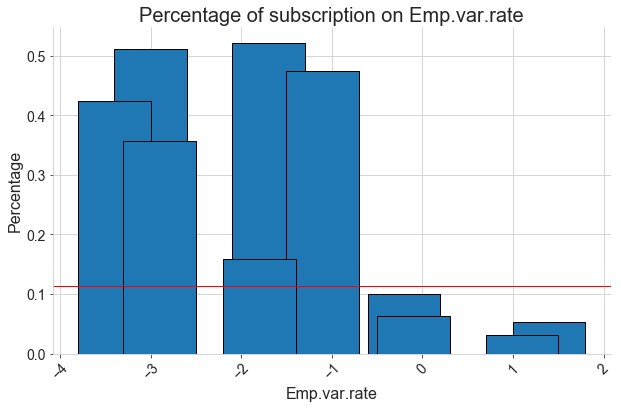

In [32]:
ybarplot('emp.var.rate')

The negative values have higher outcome

### `cons.price.idx`

In [33]:
df_exp['cons.price.idx'].describe()

count    41188.000000
mean        93.575664
std          0.578840
min         92.201000
25%         93.075000
50%         93.749000
75%         93.994000
max         94.767000
Name: cons.price.idx, dtype: float64

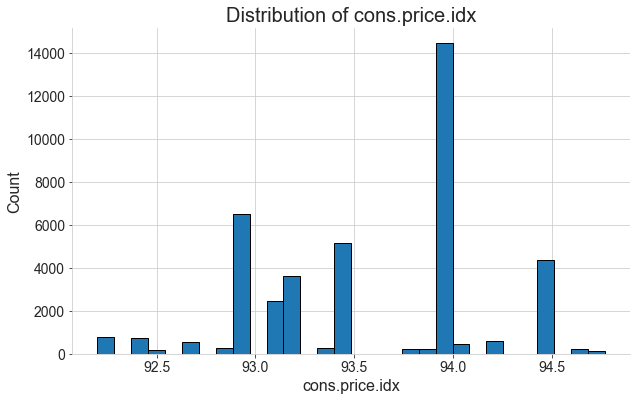

In [34]:
histplot('cons.price.idx', bins = 30)

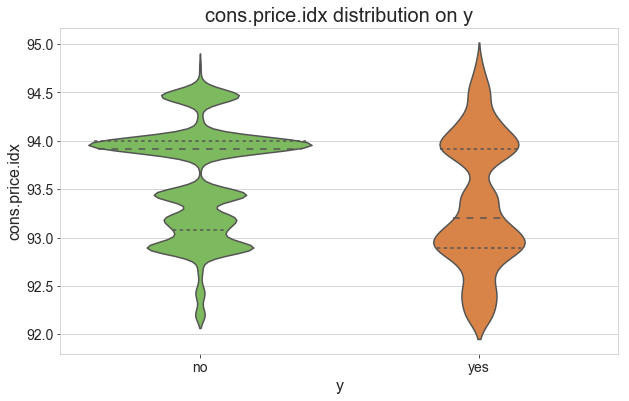

In [35]:
yviolplot('cons.price.idx')

In average, the positive outcomes have lower consumer price.

cpi_group
92 - 92.75       0.397992
92.75 - 93.25    0.120155
93.25 - 93.75    0.092286
93.75 - 94.25    0.086313
94.25 - 100      0.072036
Name: y, dtype: float64


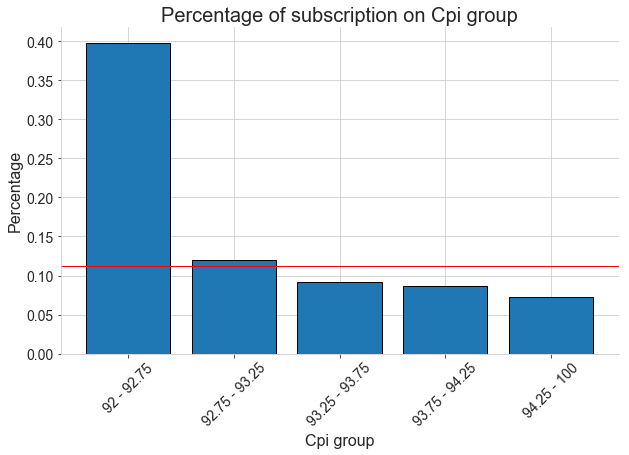

In [36]:
cut_range = [92,] + list(np.arange(92.75, 94.7, 0.5)) + [100,]
labels = ['{0} - {1}'.format(cut_range[i], cut_range[i+1]) for i in range(len(cut_range) - 1)]
df_exp['cpi_group'] = pd.cut(df_exp['cons.price.idx'], cut_range, right = False, labels = labels)
ybarplot('cpi_group', col = labels)

In [37]:
np.arange(92.25, 94.8, 0.5)

array([92.25, 92.75, 93.25, 93.75, 94.25, 94.75])

### `cons.conf.idx`

In [38]:
df_exp['cons.conf.idx'].describe()

count    41188.000000
mean       -40.502600
std          4.628198
min        -50.800000
25%        -42.700000
50%        -41.800000
75%        -36.400000
max        -26.900000
Name: cons.conf.idx, dtype: float64

In [39]:
df_exp['cons.conf.idx'].nunique()

26

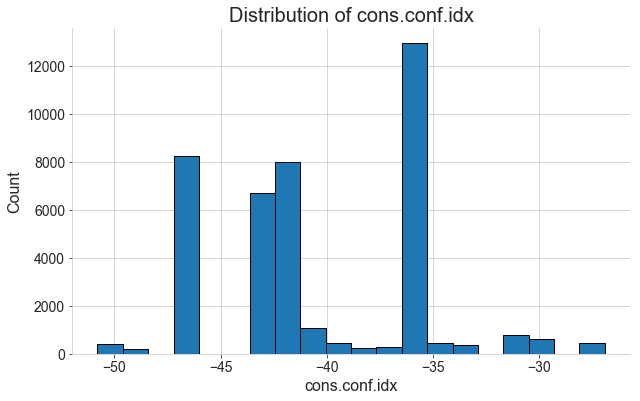

In [40]:
histplot('cons.conf.idx', bins = 20)

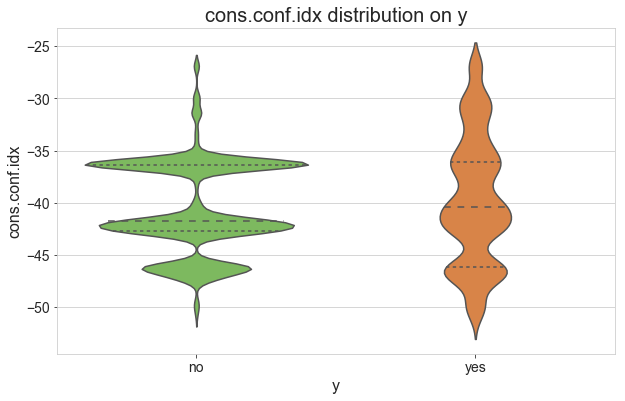

In [41]:
yviolplot('cons.conf.idx')

cci_group
-55 - -50    0.453125
-50 - -45    0.135574
-45 - -40    0.080353
-40 - -35    0.072584
-35 - -30    0.434987
-30 - -25    0.400560
Name: y, dtype: float64


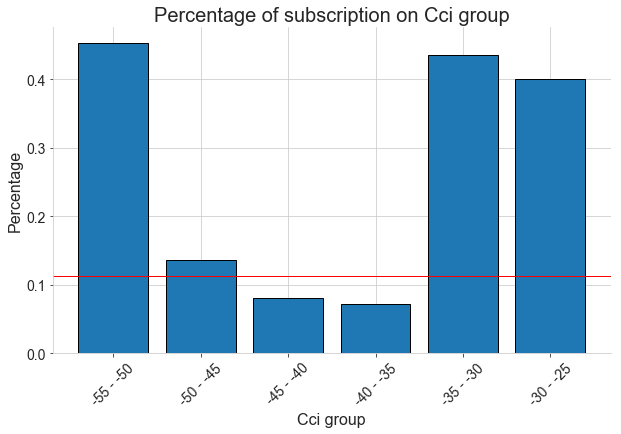

In [42]:
cut_range = list(range(-55, -24,5))
labels = ['{0} - {1}'.format(cut_range[i], cut_range[i+1]) for i in range(len(cut_range) - 1)]
df_exp['cci_group'] = pd.cut(df_exp['cons.conf.idx'], cut_range, right = False, labels = labels)
ybarplot('cci_group', col = labels)

### `euribor3m`

In [43]:
df_exp['euribor3m'].describe()

count    41188.000000
mean         3.621291
std          1.734447
min          0.634000
25%          1.344000
50%          4.857000
75%          4.961000
max          5.045000
Name: euribor3m, dtype: float64

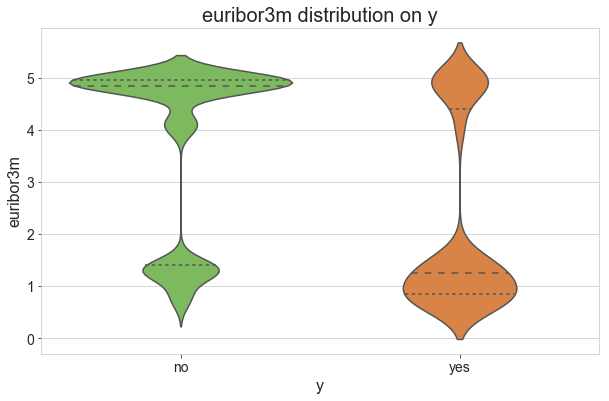

In [44]:
yviolplot('euribor3m')

eb3_group
0 - 3    0.244555
3 - 6    0.048357
Name: y, dtype: float64


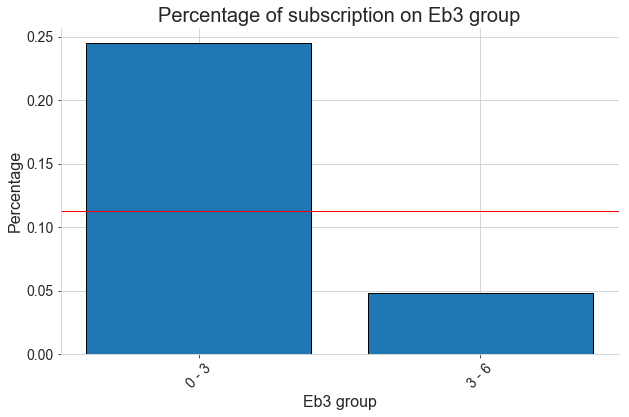

In [45]:
cut_range = [0,3,6]
labels = ['{0} - {1}'.format(cut_range[i], cut_range[i+1]) for i in range(len(cut_range) - 1)]
df_exp['eb3_group'] = pd.cut(df_exp['euribor3m'], cut_range, right = False, labels = labels)
ybarplot('eb3_group', col = labels)

This variable has very strong correlation with the outcome! (split by 3)

### `nr.employed`

In [46]:
df_exp['nr.employed'].describe()

count    41188.000000
mean      5167.035911
std         72.251528
min       4963.600000
25%       5099.100000
50%       5191.000000
75%       5228.100000
max       5228.100000
Name: nr.employed, dtype: float64

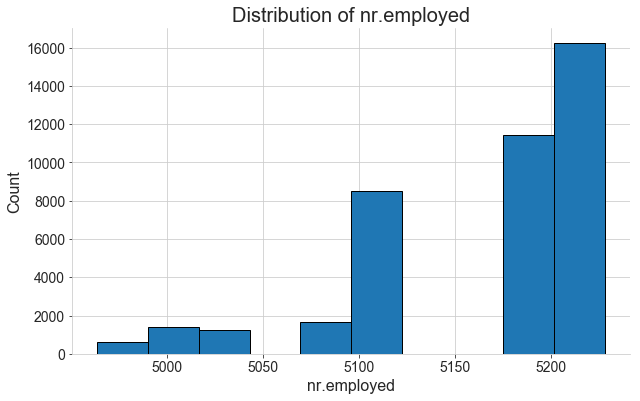

In [47]:
histplot('nr.employed')

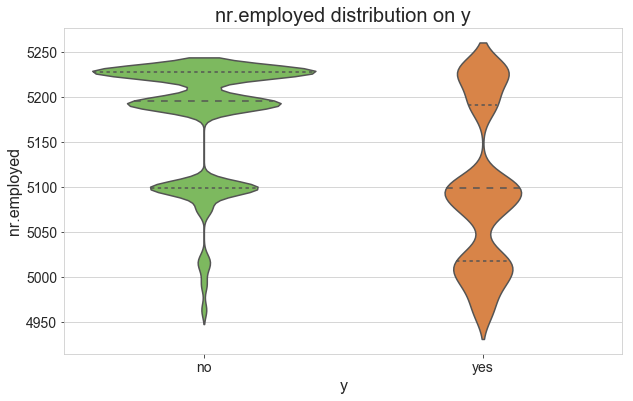

In [48]:
yviolplot('nr.employed')

ne_group
4900 - 5050    0.489246
5050 - 5150    0.165343
5150 - 5300    0.048357
Name: y, dtype: float64


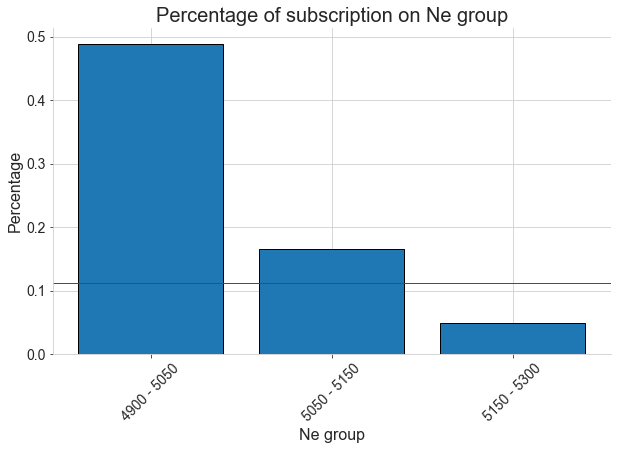

In [49]:
cut_range = [4900,5050, 5150, 5300]
labels = ['{0} - {1}'.format(cut_range[i], cut_range[i+1]) for i in range(len(cut_range) - 1)]
df_exp['ne_group'] = pd.cut(df_exp['nr.employed'], cut_range, right = False, labels = labels)
ybarplot('ne_group', col = labels)

### `job`

Define a function to make the bar plot.

In [50]:
def barplot(name, in_df = df_exp, returncontrol = False, col = None):
    plot_col = in_df[name].value_counts()
    if col is not None:
        plot_col = plot_col.reindex(col)
        plot_col = plot_col.fillna(0)
    print(plot_col)
    out_name = name.replace('_', ' ').capitalize()
    fig, ax = plt.subplots(figsize = (10,6))
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    plt.title('Distribution of ' + out_name, 
               fontdict = {'fontsize': 20,
                           'fontweight': 500})
    plt.xticks(fontsize=14, rotation=45)  
    plt.yticks(fontsize=14)
    plt.xlabel(out_name, fontsize=16)  
    plt.ylabel("Count", fontsize=16)
    plt.bar(plot_col.index, plot_col.values, edgecolor='black');
    if returncontrol: return fig

In [51]:
df_exp['job'].unique()

array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed', nan,
       'entrepreneur', 'student'], dtype=object)

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
Name: job, dtype: int64


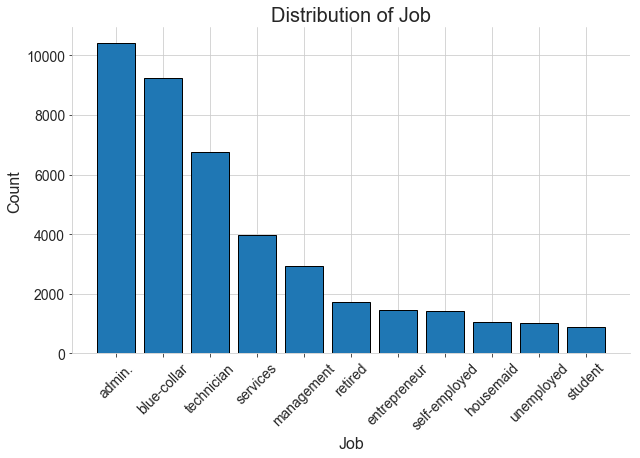

In [52]:
barplot('job')

job
student          0.314286
retired          0.252326
unemployed       0.142012
admin.           0.129726
management       0.112175
technician       0.108260
self-employed    0.104856
housemaid        0.100000
entrepreneur     0.085165
services         0.081381
blue-collar      0.068943
Name: y, dtype: float64


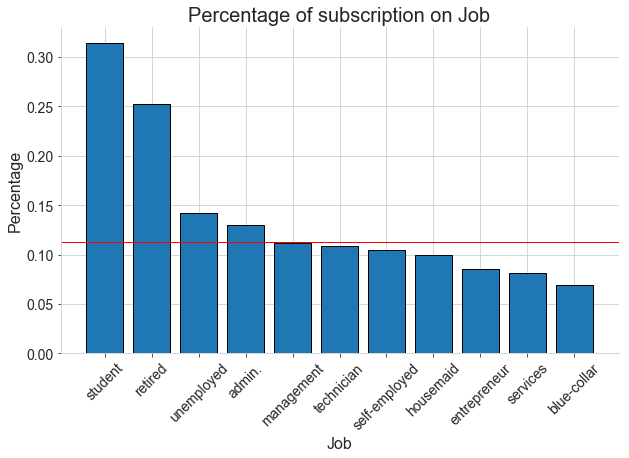

In [53]:
ybarplot('job')

`student` and `retired` have much higher outcome rate than others. It is in an agreement with the age distribution, that age larger than 60 and less than 20 have the higher outcome rate.

### `marital`

married     24928
single      11568
divorced     4612
Name: marital, dtype: int64


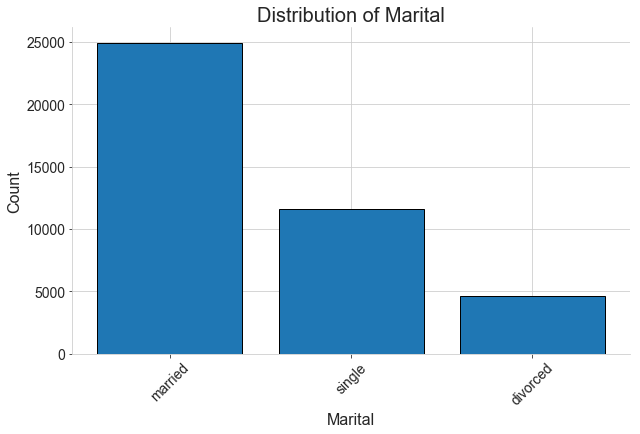

In [54]:
barplot('marital')

marital
single      0.140041
divorced    0.103209
married     0.101573
Name: y, dtype: float64


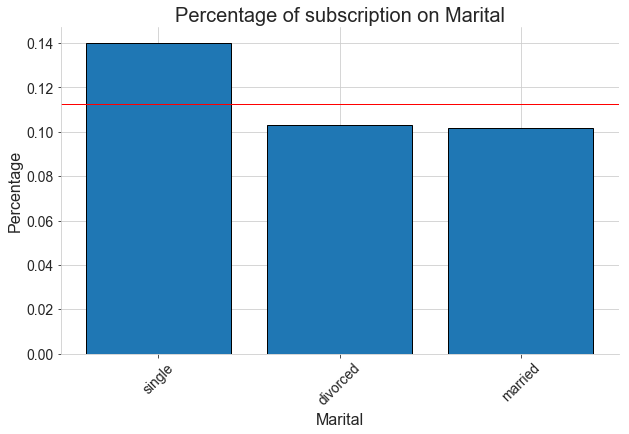

In [55]:
ybarplot('marital')

`Single` has the highest outcome rate. 

### `education`

In [56]:
df_exp['education'].unique()

array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', nan, 'university.degree', 'illiterate'],
      dtype=object)

university.degree      12168
professional.course     5243
high.school             9515
basic.9y                6045
basic.6y                2292
basic.4y                4176
illiterate                18
Name: education, dtype: int64


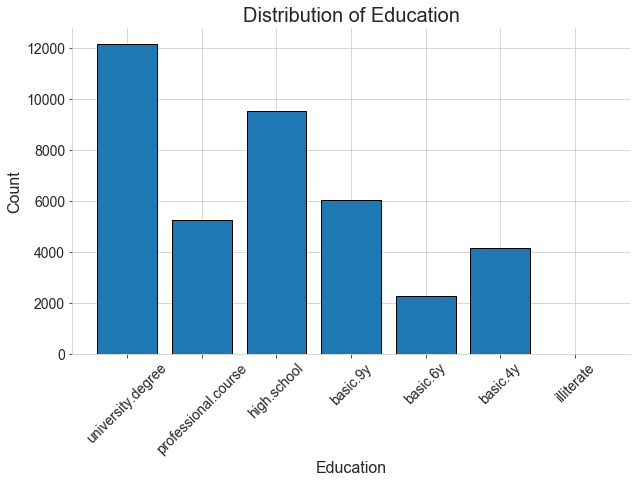

In [57]:
col = ["illiterate","basic.4y","basic.6y","basic.9y","high.school","professional.course","university.degree"]
col.reverse()
barplot('education', col = col)

education
illiterate             0.222222
university.degree      0.137245
professional.course    0.113485
high.school            0.108355
basic.4y               0.102490
basic.6y               0.082024
basic.9y               0.078246
Name: y, dtype: float64


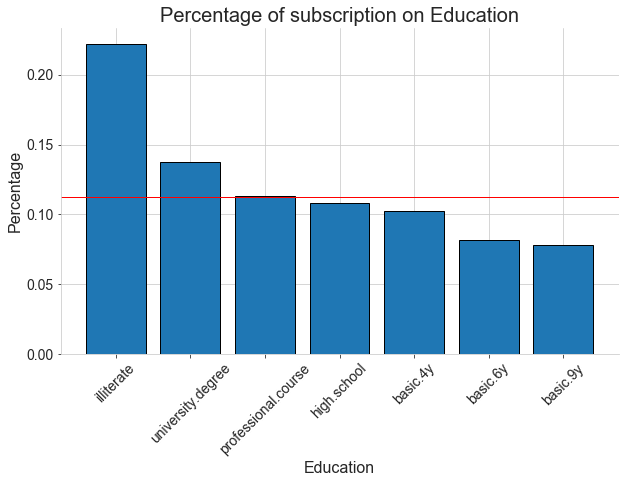

In [58]:
ybarplot('education')

`illiterate` and `university.degree` have the higher outcome rate. Does it related to `age`? Let's explore on that.

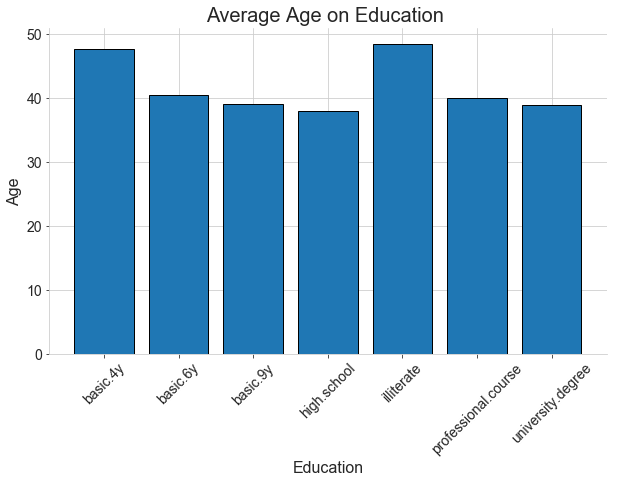

In [59]:
age_edu = df_exp.groupby('education')['age'].mean()
fig, ax = plt.subplots(figsize = (10,6))
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
plt.title('Average Age on Education ',
          fontdict = {'fontsize': 20,
                      'fontweight': 500})
plt.xticks(fontsize=14, rotation=45)  
plt.yticks(fontsize=14)
plt.xlabel('Education', fontsize=16)  
plt.ylabel("Age", fontsize=16)
plt.bar(age_edu.index, age_edu.values, edgecolor='black');

Clearly, it is not because of `age`.

### `default`

no     32588
yes        3
Name: default, dtype: int64


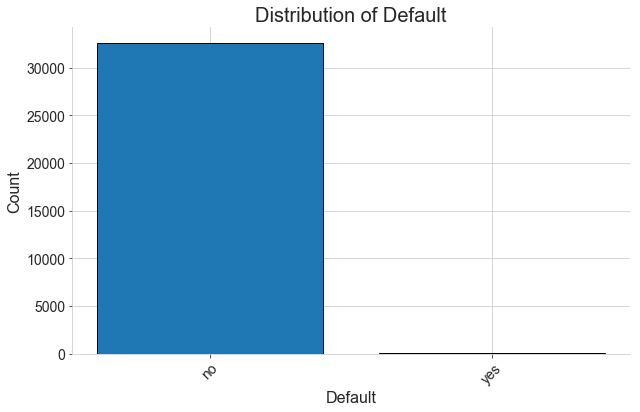

In [60]:
barplot('default')

Very unbalance.

### `housing`

yes    21576
no     18622
Name: housing, dtype: int64


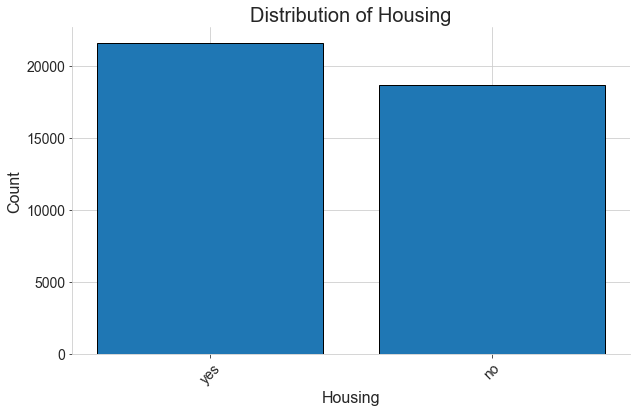

In [61]:
barplot('housing')

housing
yes    0.116194
no     0.108796
Name: y, dtype: float64


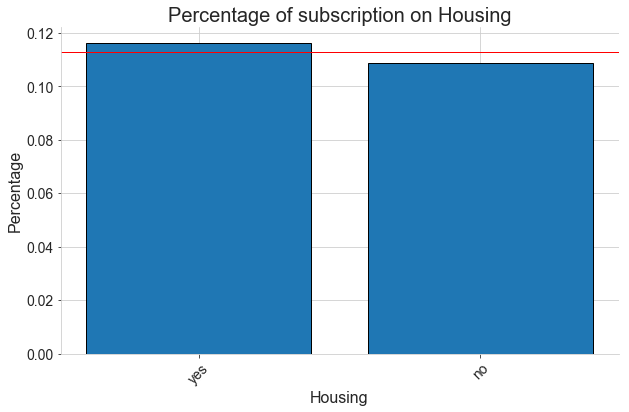

In [62]:
ybarplot('housing')

Not much difference...

### `loan`

no     33950
yes     6248
Name: loan, dtype: int64


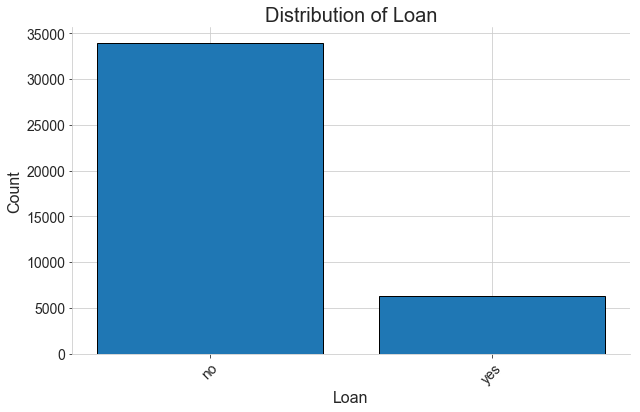

In [63]:
barplot('loan')

loan
no     0.113402
yes    0.109315
Name: y, dtype: float64


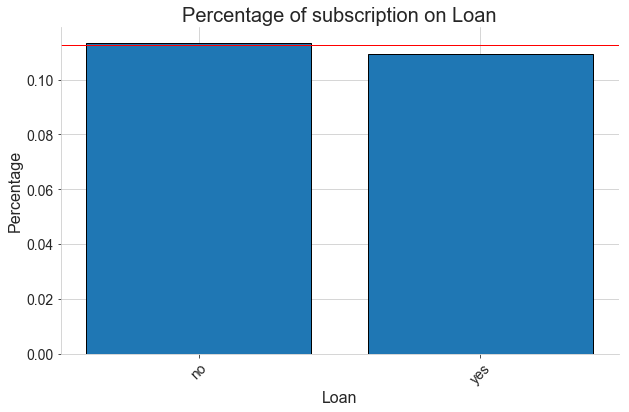

In [64]:
ybarplot('loan')

### `contact`

cellular     26144
telephone    15044
Name: contact, dtype: int64


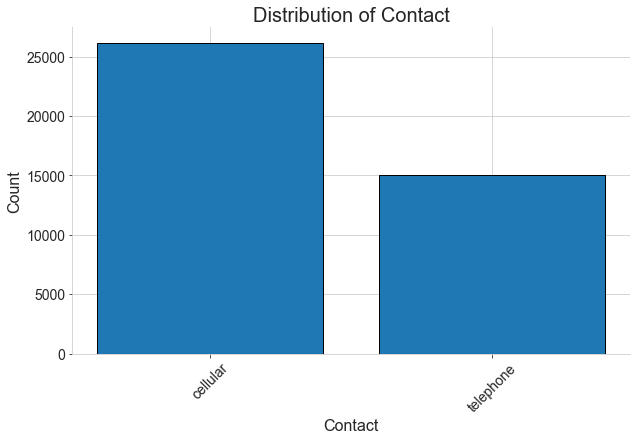

In [65]:
barplot('contact')

contact
cellular     0.147376
telephone    0.052313
Name: y, dtype: float64


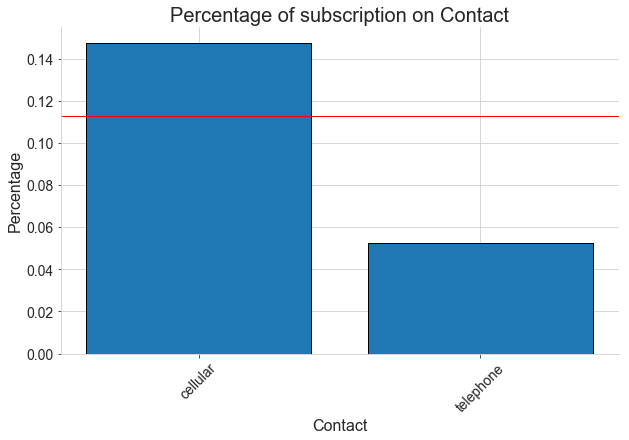

In [66]:
ybarplot('contact')

`cellular` has obviously higher rate than `telephone`.

### `month`

jan        0.0
feb        0.0
mar      546.0
apr     2632.0
may    13769.0
jun     5318.0
jul     7174.0
aug     6178.0
sep      570.0
oct      718.0
nov     4101.0
dec      182.0
Name: month, dtype: float64


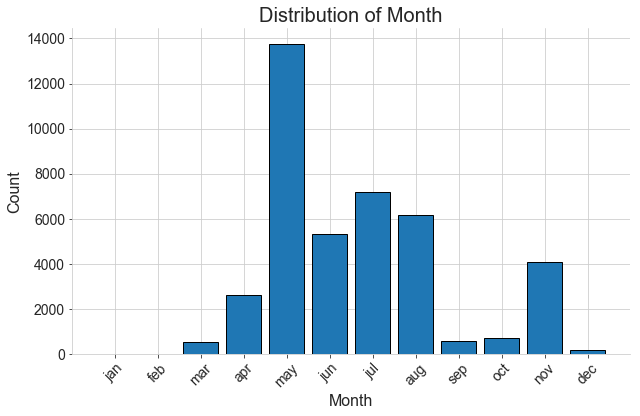

In [67]:
col = ["jan", "feb", "mar", 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', "nov", "dec"]
barplot('month', col = col)

month
jan    0.000000
feb    0.000000
mar    0.505495
apr    0.204787
may    0.064347
jun    0.105115
jul    0.090466
aug    0.106021
sep    0.449123
oct    0.438719
nov    0.101439
dec    0.489011
Name: y, dtype: float64


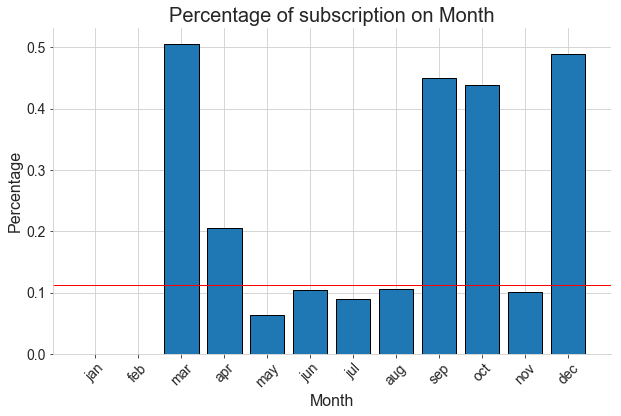

In [68]:
ybarplot('month', col = col)

It is interesting! The rate distribution is just opposite to the count distribution. The salesman stops working after reaching the goal???

### `day_of_week`

mon    8514
tue    8090
wed    8134
thu    8623
fri    7827
Name: day_of_week, dtype: int64


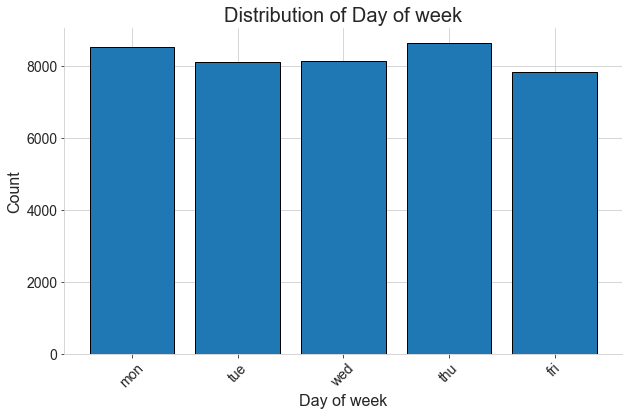

In [69]:
col = ["mon","tue","wed","thu","fri"]
barplot('day_of_week', col = col)

day_of_week
mon    0.099483
tue    0.117800
wed    0.116671
thu    0.121188
fri    0.108087
Name: y, dtype: float64


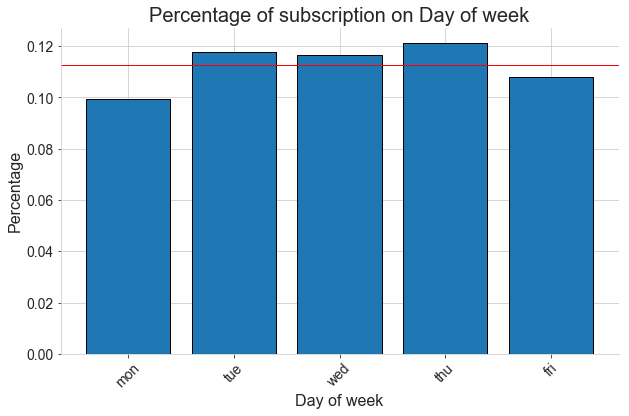

In [70]:
ybarplot('day_of_week', col = col)

In [71]:
tot = df_exp.groupby(['month','day_of_week'])['y'].count()
suc = df_exp[df_exp['y'] == 'yes'].groupby(['month','day_of_week'])['y'].count()
md_series = suc/tot
df_md = md_series.unstack(level=-1)

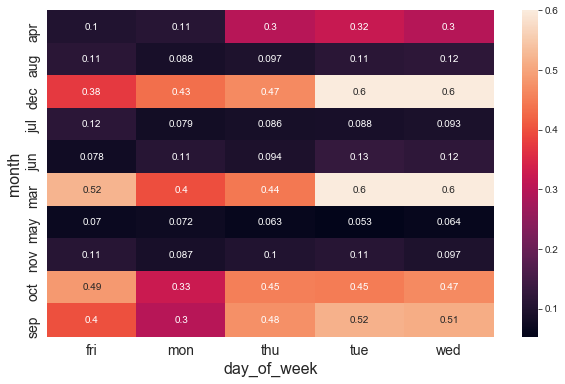

In [72]:
fig, ax = plt.subplots(figsize = (10,6))
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.xlabel('Day of Week',fontsize=16)  
plt.ylabel('Month',fontsize=16)
sns.heatmap(df_md, annot=True);

### `poutcome`

nonexistent    35563
failure         4252
success         1373
Name: poutcome, dtype: int64


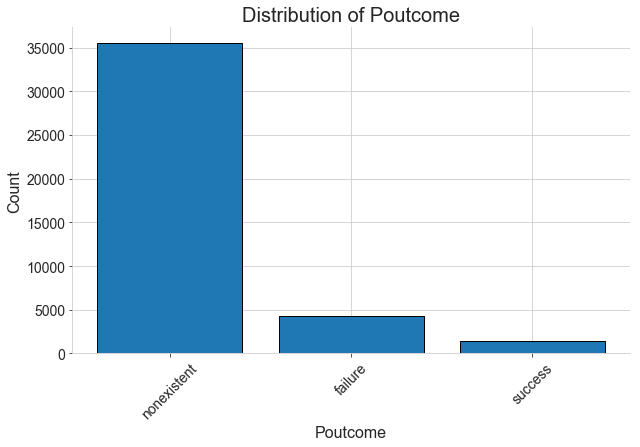

In [73]:
barplot('poutcome')

poutcome
success        0.651129
failure        0.142286
nonexistent    0.088322
Name: y, dtype: float64


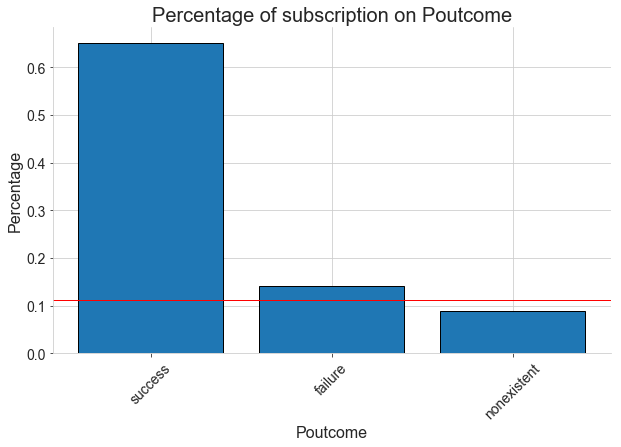

In [74]:
ybarplot('poutcome')

Cases successed before have higher outcome rate.

## Summary of EDA and prepare the data for ML

Most of the parameters have strong correlationship with the outcome. For example, `age` larger than 60 or less than 20 have obviously higher outcome rate, so are many other variables. 

The categorical data need to be transfered to numerical data. 

In [75]:
# create the training data from the original dataset. 
df_train = df.loc[:, df.columns != 'y']
df_train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


In [76]:
# create the label data, and transfer the data to binary code.
df_y = df['y'].replace({'yes': 1, 'no': 0})
df_y.head()

0    0
1    0
2    0
3    0
4    0
Name: y, dtype: int64

In [77]:
# replace the `unknown` to nan
df_train = df_train.replace('unknown', np.nan)

In [78]:
# make a copy for the training data
df_x = df_train.copy()

In [79]:
# manually change some categorical to numerical
df_x['default'] = df_x['default'].replace({'yes': 1, 'no': 0})
df_x['housing'] = df_x['housing'].replace({'yes': 1, 'no': 0})
df_x['loan'] = df_x['loan'].replace({'yes': 1, 'no': 0})
df_x['contact'] = df_x['contact'].replace({'cellular': 1, 'telephone': 0})
df_x = df_x.rename({'contact':'cellular'},axis = 1)
df_x = df_x.drop('duration', axis = 1)
df_x['poutcome'] = df_x['poutcome'].replace('nonexistent', np.nan)
df_x['poutcome'] = df_x['poutcome'].replace({'success': 1, 'failure': 0})

In [80]:
df_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 19 columns):
age               41188 non-null int64
job               40858 non-null object
marital           41108 non-null object
education         39457 non-null object
default           32591 non-null float64
housing           40198 non-null float64
loan              40198 non-null float64
cellular          41188 non-null int64
month             41188 non-null object
day_of_week       41188 non-null object
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          5625 non-null float64
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
dtypes: float64(9), int64(5), object(5)
memory usage: 6.0+ MB


5 categorical variables remaining.

In [81]:
# three more
df_x['month'] = df_x['month'].replace(to_replace = ['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'mar', 'apr',
       'sep'], value = [5,6,7,8,10,11,12,3,4,9])
df_x['day_of_week'] = df_x['day_of_week'].replace(to_replace = ['mon', 'tue', 'wed', 'thu', 'fri'], 
                                                  value = [1,2,3,4,5])
df_x['education'] = df_x['education'].replace(to_replace = ['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'university.degree', 'illiterate'], value = [2,5,3,4,6,7,1])

In [82]:
# use LabelEncoder() transfer the `job`
le = LabelEncoder()

# it cannot transfer the np.nan, because it is the type of float. That's the reason to use astype('str')
df_x['job'] = le.fit_transform(df_x['job'].astype('str'))

# XGBoost can handle the missing value, so change the coded nan to missing value.
df_x['job'] = df_x['job'].replace({5: np.nan})

In [83]:
# use get_dummies() to transfer the one last parameter
df_x = pd.get_dummies(df_x)

In [84]:
# check
df_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age                 41188 non-null int64
job                 40858 non-null float64
education           39457 non-null float64
default             32591 non-null float64
housing             40198 non-null float64
loan                40198 non-null float64
cellular            41188 non-null int64
month               41188 non-null int64
day_of_week         41188 non-null int64
campaign            41188 non-null int64
pdays               41188 non-null int64
previous            41188 non-null int64
poutcome            5625 non-null float64
emp.var.rate        41188 non-null float64
cons.price.idx      41188 non-null float64
cons.conf.idx       41188 non-null float64
euribor3m           41188 non-null float64
nr.employed         41188 non-null float64
marital_divorced    41188 non-null uint8
marital_married     41188 non-null uint8
marital_single      41188 non-null uint8
dtypes: f

All numerical now.

## Gradient Boost Model

In [122]:
# prepare the training, validation and testing dataset
X_train, X_test, y_train, y_test = train_test_split(df_x.values, df_y.values, test_size=0.1, random_state=13)
X_train, X_vali, y_train, y_vali = train_test_split(X_train, y_train, test_size=0.2, random_state=13)

In [123]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvali = xgb.DMatrix(X_vali, label = y_vali)
dtest = xgb.DMatrix(X_test)

### Model 1

In [114]:
params = {
    # logistic regression for binary classification, output probability
    'objective': 'binary:logistic',
    # the depth of each tree
    'max_depth': 3,
    # usually 0.1~0.01
    'learning_rate': 0.1,
    # 1 means silent mode, 0 is printing running messages
    'silent': 1,   
    # number of trees to fit
    'n_estimators': 500,
    # early stop, prevent overfitting, stops the training when the performance doesn't improve after this rounds.
    'early_stopping_rounds': 30,
    # ratio of data(rows) used in the model
    'subsample': 0.8,
    # ration of parameters (columns) used for each tree
    'colsample_bytree': 1,
    # regularization paramter, usually 0,1,5
    'gamma': 1    
}
# use two metrics; auc is the area under curve(roc curve)
params['eval_metric'] = ['error', 'auc']
# make a watchlist, to output the performance while training
watchlist  = [(dvali,'validation'), (dtrain,'train')]
# the number of epoch
num_rounds = 100

evals_result = {}

In [115]:
bst_1 = xgb.train(params, dtrain, num_rounds, watchlist, evals_result = evals_result)

[0]	validation-error:0.102239	validation-auc:0.748627	train-error:0.101872	train-auc:0.751761
[1]	validation-error:0.10089	validation-auc:0.748396	train-error:0.101602	train-auc:0.75284
[2]	validation-error:0.10089	validation-auc:0.748923	train-error:0.101602	train-auc:0.753557
[3]	validation-error:0.100216	validation-auc:0.771799	train-error:0.101332	train-auc:0.776382
[4]	validation-error:0.100216	validation-auc:0.779093	train-error:0.101332	train-auc:0.781431
[5]	validation-error:0.100216	validation-auc:0.779044	train-error:0.101298	train-auc:0.781197
[6]	validation-error:0.100351	validation-auc:0.783041	train-error:0.101231	train-auc:0.783233
[7]	validation-error:0.100216	validation-auc:0.783153	train-error:0.101366	train-auc:0.783282
[8]	validation-error:0.100081	validation-auc:0.783163	train-error:0.101433	train-auc:0.783391
[9]	validation-error:0.099946	validation-auc:0.782574	train-error:0.101298	train-auc:0.783565
[10]	validation-error:0.100216	validation-auc:0.782885	train-er

[87]	validation-error:0.10089	validation-auc:0.805161	train-error:0.097218	train-auc:0.810643
[88]	validation-error:0.10089	validation-auc:0.80518	train-error:0.097184	train-auc:0.81067
[89]	validation-error:0.10089	validation-auc:0.805182	train-error:0.097184	train-auc:0.810827
[90]	validation-error:0.10089	validation-auc:0.805042	train-error:0.097151	train-auc:0.811049
[91]	validation-error:0.100755	validation-auc:0.804972	train-error:0.097151	train-auc:0.811236
[92]	validation-error:0.10062	validation-auc:0.805036	train-error:0.097184	train-auc:0.811529
[93]	validation-error:0.100486	validation-auc:0.805003	train-error:0.097117	train-auc:0.81165
[94]	validation-error:0.100351	validation-auc:0.805205	train-error:0.096948	train-auc:0.811932
[95]	validation-error:0.100351	validation-auc:0.805207	train-error:0.096982	train-auc:0.811942
[96]	validation-error:0.100486	validation-auc:0.805247	train-error:0.096948	train-auc:0.811946
[97]	validation-error:0.100755	validation-auc:0.805219	tra

In [106]:
len(evals_result['train']['auc'])

200

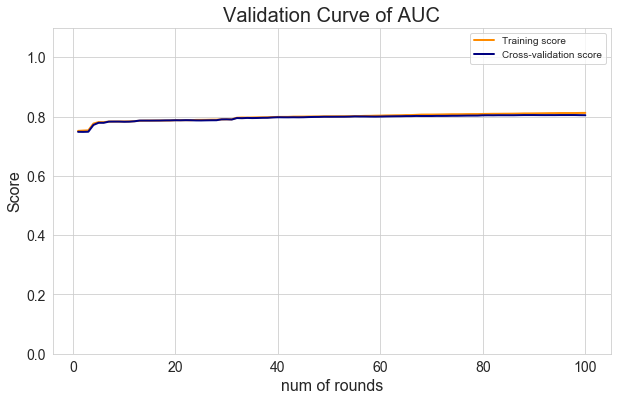

In [117]:
train_scores_mean = evals_result['train']['auc']
#train_scores_std = np.std(train_scores, axis=1)
vali_scores_mean = evals_result['validation']['auc']
#vali_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize = (10,6))
plt.title("Validation Curve of AUC", fontsize=20)
plt.xlabel("num of rounds", fontsize=16)
plt.ylabel("Score", fontsize=16)
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(list(range(1,num_rounds+1)), train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
#plt.fill_between(param_range, train_scores_mean - train_scores_std,
#                 train_scores_mean + train_scores_std, alpha=0.2,
#                 color="darkorange", lw=lw)
plt.plot(list(range(1,num_rounds+1)), vali_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
#plt.fill_between(param_range, test_scores_mean - test_scores_std,
#                 test_scores_mean + test_scores_std, alpha=0.2,
#                 color="navy", lw=lw)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.legend(loc="best")
plt.show()

In [124]:
preds = bst_1.predict(dtest)

In [128]:
preds_binary = [1 if i>0.5 else 0 for i in preds]

In [131]:
roc_auc_score(preds_binary, y_test)

0.7912240768841678

Introduce the cross validation mechanism

In [148]:
# only prepare the training and testing dataset, the validation data will be seperated later
X_train, X_test, y_train, y_test = train_test_split(df_x.values, df_y.values, test_size=0.1, random_state=13)

In [170]:
params = {
    # logistic regression for binary classification, output probability
    'objective': 'binary:logistic',
    # the depth of each tree
    'max_depth': 5,
    # usually 0.1~0.01
    'learning_rate': 0.1,
    # 1 means silent mode, 0 is printing running messages
    'silent': 1,   
    # number of trees to fit
    'n_estimators': 500,
    # early stop, prevent overfitting, stops the training when the performance doesn't improve after this rounds.
    'early_stopping_rounds': 30,
    # ratio of data(rows) used in the model
    #'subsample': 0.8,
    # ration of parameters (columns) used for each tree
    'colsample_bytree': 1,
    # regularization paramter, usually 0,1,5
    'gamma': 1    
}
# use two metrics; auc is the area under curve(roc curve)
params['eval_metric'] = ['auc']

# the number of epoch
num_rounds = 100

In [150]:
from sklearn.model_selection import KFold

In [151]:
theshold = 0.5
kf = KFold(n_splits = 10)
cv_score = []
for train_index, test_index in kf.split(X_train):
    print("%s %s" % (train_index, test_index))
    X_in_train, X_in_vali = X_train[train_index], X_train[test_index]
    y_in_train, y_in_vali = y_train[train_index], y_train[test_index]
    dtrain = xgb.DMatrix(X_in_train, label=y_in_train)
    dvali = xgb.DMatrix(X_in_vali)
    bst_2 = xgb.train(params, dtrain, num_rounds)
    preds_binary = [1 if i>theshold else 0 for i in bst_2.predict(dvali)]
    cv_score.append(roc_auc_score(preds_binary, y_in_vali))

[ 3707  3708  3709 ... 37066 37067 37068] [   0    1    2 ... 3704 3705 3706]
[    0     1     2 ... 37066 37067 37068] [3707 3708 3709 ... 7411 7412 7413]
[    0     1     2 ... 37066 37067 37068] [ 7414  7415  7416 ... 11118 11119 11120]
[    0     1     2 ... 37066 37067 37068] [11121 11122 11123 ... 14825 14826 14827]
[    0     1     2 ... 37066 37067 37068] [14828 14829 14830 ... 18532 18533 18534]
[    0     1     2 ... 37066 37067 37068] [18535 18536 18537 ... 22239 22240 22241]
[    0     1     2 ... 37066 37067 37068] [22242 22243 22244 ... 25946 25947 25948]
[    0     1     2 ... 37066 37067 37068] [25949 25950 25951 ... 29653 29654 29655]
[    0     1     2 ... 37066 37067 37068] [29656 29657 29658 ... 33360 33361 33362]
[    0     1     2 ... 33360 33361 33362] [33363 33364 33365 ... 37066 37067 37068]


In [152]:
np.mean(cv_score)

0.7897827676545843

In [153]:
preds_binary = [1 if i>0.5 else 0 for i in bst_2.predict(dtest)]
roc_auc_score(preds_binary, y_test)

0.8048880233690361

Use the validation_curve function

In [154]:
from sklearn.model_selection import validation_curve

In [155]:
sss = XGBClassifier(**params)

In [178]:
params = {
    # logistic regression for binary classification, output probability
    'objective': 'binary:logistic',
    # the depth of each tree
    'max_depth': 5,
    # usually 0.1~0.01
    'learning_rate': 0.1,
    # 1 means silent mode, 0 is printing running messages
    'silent': 1,   
    # number of trees to fit
    'n_estimators': 500,
    # early stop, prevent overfitting, stops the training when the performance doesn't improve after this rounds.
    'early_stopping_rounds': 30,
    # ratio of data(rows) used in the model
    'subsample': 0.5,
    # ratio of parameters (columns) used for each tree
    'colsample_bytree': 0.8,
    # regularization paramter, usually 0,1,5
    #'gamma': 1    
}
# use two metrics; auc is the area under curve(roc curve)
params['eval_metric'] = ['auc']
param_range=range(0,6)
train_scores, test_scores = validation_curve(
    sss, X_train, y_train, param_name="gamma", param_range=param_range,
    cv=10, scoring="f1", n_jobs=1)

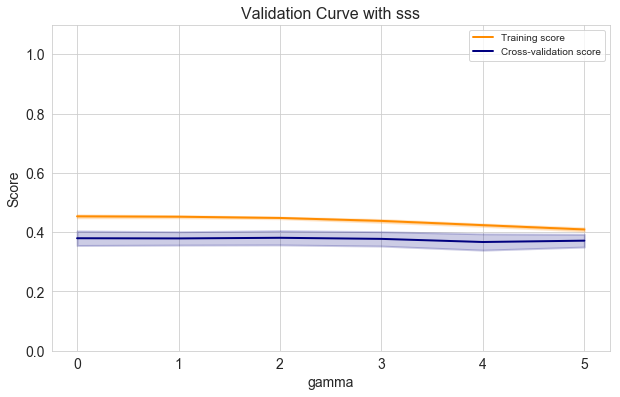

In [179]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize = (10,6))
plt.title("Validation Curve with sss", fontsize=16)
plt.xlabel("gamma", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()

After adjust the parameters using the validation curve, use the combination of the parameters to obtain bst_3 model.

In [181]:
params = {
    # logistic regression for binary classification, output probability
    'objective': 'binary:logistic',
    # the depth of each tree
    'max_depth': 5,
    # usually 0.1~0.01
    'learning_rate': 0.1,
    # 1 means silent mode, 0 is printing running messages
    'silent': 1,   
    # number of trees to fit
    'n_estimators': 500,
    # early stop, prevent overfitting, stops the training when the performance doesn't improve after this rounds.
    'early_stopping_rounds': 30,
    # ratio of data(rows) used in the model
    'subsample': 0.5,
    # ratio of parameters (columns) used for each tree
    'colsample_bytree': 0.8,
    # regularization paramter, usually 0,1,5
    'gamma': 3   
}
# use two metrics; auc is the area under curve(roc curve)
params['eval_metric'] = ['auc']

In [182]:
theshold = 0.5
kf = KFold(n_splits = 10)
cv_score = []
for train_index, test_index in kf.split(X_train):
    print("%s %s" % (train_index, test_index))
    X_in_train, X_in_vali = X_train[train_index], X_train[test_index]
    y_in_train, y_in_vali = y_train[train_index], y_train[test_index]
    dtrain = xgb.DMatrix(X_in_train, label=y_in_train)
    dvali = xgb.DMatrix(X_in_vali)
    bst_3 = xgb.train(params, dtrain, num_rounds)
    preds_binary = [1 if i>theshold else 0 for i in bst_3.predict(dvali)]
    cv_score.append(f1_score(preds_binary, y_in_vali))

[ 3707  3708  3709 ... 37066 37067 37068] [   0    1    2 ... 3704 3705 3706]
[    0     1     2 ... 37066 37067 37068] [3707 3708 3709 ... 7411 7412 7413]
[    0     1     2 ... 37066 37067 37068] [ 7414  7415  7416 ... 11118 11119 11120]
[    0     1     2 ... 37066 37067 37068] [11121 11122 11123 ... 14825 14826 14827]
[    0     1     2 ... 37066 37067 37068] [14828 14829 14830 ... 18532 18533 18534]
[    0     1     2 ... 37066 37067 37068] [18535 18536 18537 ... 22239 22240 22241]
[    0     1     2 ... 37066 37067 37068] [22242 22243 22244 ... 25946 25947 25948]
[    0     1     2 ... 37066 37067 37068] [25949 25950 25951 ... 29653 29654 29655]
[    0     1     2 ... 37066 37067 37068] [29656 29657 29658 ... 33360 33361 33362]
[    0     1     2 ... 33360 33361 33362] [33363 33364 33365 ... 37066 37067 37068]


In [183]:
np.mean(cv_score)

0.37001700617389244

In [184]:
preds_binary = [1 if i>0.5 else 0 for i in bst_2.predict(dtest)]
f1_score(preds_binary, y_test)

0.38235294117647056

In [241]:
dtest = xgb.DMatrix(X_test)
y_test_preds = (bst_3.predict(dtest) > 0.5).astype('int')
pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
0,3611,65,3676
1,319,124,443
All,3930,189,4119


In [242]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_test_preds)))

Accuracy: 0.91
Precision: 0.66
Recall: 0.28


Since the dataset is very unbalanced, need to weight the label.

In [186]:
params = {
    # logistic regression for binary classification, output probability
    'objective': 'binary:logistic',
    # the depth of each tree
    'max_depth': 5,
    # usually 0.1~0.01
    'learning_rate': 0.1,
    # 1 means silent mode, 0 is printing running messages
    'silent': 1,   
    # number of trees to fit
    'n_estimators': 500,
    # early stop, prevent overfitting, stops the training when the performance doesn't improve after this rounds.
    'early_stopping_rounds': 30,
    # ratio of data(rows) used in the model
    'subsample': 0.5,
    # ratio of parameters (columns) used for each tree
    'colsample_bytree': 0.8,
    # regularization paramter, usually 0,1,5
    'gamma': 3   
}
# use two metrics; auc is the area under curve(roc curve)
params['eval_metric'] = ['auc']

In [187]:
theshold = 0.5
kf = KFold(n_splits = 10)
cv_score = []
for train_index, test_index in kf.split(X_train):
    print("%s %s" % (train_index, test_index))
    X_in_train, X_in_vali = X_train[train_index], X_train[test_index]
    y_in_train, y_in_vali = y_train[train_index], y_train[test_index]
    # add the weights here
    weights = np.zeros(len(y_in_train))
    weights[y_in_train == 0] = 1
    weights[y_in_train == 1] = 5
    dtrain = xgb.DMatrix(X_in_train, label=y_in_train,  weight=weights) # weights added
    dvali = xgb.DMatrix(X_in_vali)
    bst_4 = xgb.train(params, dtrain, num_rounds)
    preds_binary = [1 if i>theshold else 0 for i in bst_4.predict(dvali)]
    cv_score.append(f1_score(preds_binary, y_in_vali))

[ 3707  3708  3709 ... 37066 37067 37068] [   0    1    2 ... 3704 3705 3706]
[    0     1     2 ... 37066 37067 37068] [3707 3708 3709 ... 7411 7412 7413]
[    0     1     2 ... 37066 37067 37068] [ 7414  7415  7416 ... 11118 11119 11120]
[    0     1     2 ... 37066 37067 37068] [11121 11122 11123 ... 14825 14826 14827]
[    0     1     2 ... 37066 37067 37068] [14828 14829 14830 ... 18532 18533 18534]
[    0     1     2 ... 37066 37067 37068] [18535 18536 18537 ... 22239 22240 22241]
[    0     1     2 ... 37066 37067 37068] [22242 22243 22244 ... 25946 25947 25948]
[    0     1     2 ... 37066 37067 37068] [25949 25950 25951 ... 29653 29654 29655]
[    0     1     2 ... 37066 37067 37068] [29656 29657 29658 ... 33360 33361 33362]
[    0     1     2 ... 33360 33361 33362] [33363 33364 33365 ... 37066 37067 37068]


In [188]:
np.mean(cv_score)

0.5028611189249698

In [189]:
dtest = xgb.DMatrix(X_test)
y_test_preds = (bst_4.predict(dtest) > 0.5).astype('int')
pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
0,3335,341,3676
1,172,271,443
All,3507,612,4119


In [190]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_test_preds)))

Accuracy: 0.88
Precision: 0.44
Recall: 0.61


The F1-score improves 0.1

### Re-adjust the parameters after introduce the scale_pos_weight

Parameter `scale_pos_weight`

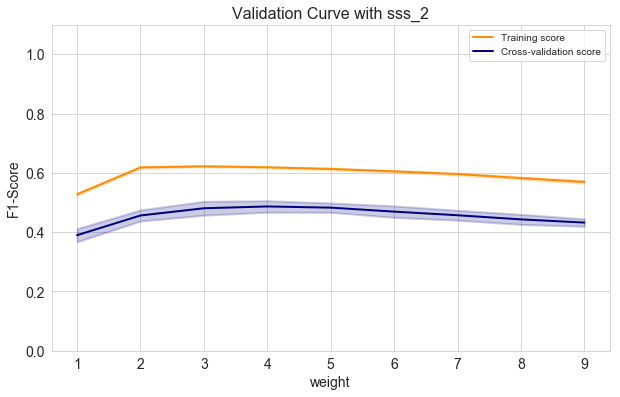

In [192]:
params = {
    # logistic regression for binary classification, output probability
    'objective': 'binary:logistic',
    # the depth of each tree
    'max_depth': 5,
    # usually 0.1~0.01
    'learning_rate': 0.1,
    # 1 means silent mode, 0 is printing running messages
    'silent': 1,   
    # number of trees to fit
    'n_estimators': 500,
    # early stop, prevent overfitting, stops the training when the performance doesn't improve after this rounds.
    'early_stopping_rounds': 30,
    # ratio of data(rows) used in the model
    'subsample': 0.5,
    # ratio of parameters (columns) used for each tree
    'colsample_bytree': 0.8,
    # regularization paramter, usually 0,1,5
    'gamma': 3,
    # Balancing of positive and negative weights
    #'scale_pos_weight': 5
}
# use two metrics; auc is the area under curve(roc curve)
params['eval_metric'] = ['auc']
sss_2 = XGBClassifier(**params)
param_range=range(1,10)
train_scores, test_scores = validation_curve(
    sss_2, X_train, y_train, param_name="scale_pos_weight", param_range=param_range,
    cv=10, scoring="f1", n_jobs=-1)


# Plot the validation curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize = (10,6))
plt.title("Validation Curve with sss_2", fontsize=16)
plt.xlabel("weight", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()

So the `scale_pos_weight` is set as 4.

Parameter `max_depth`

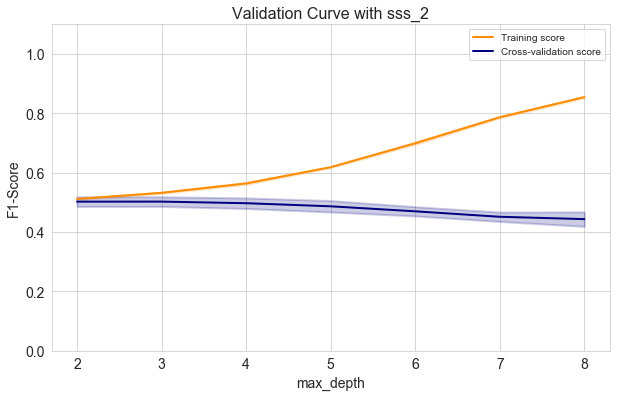

In [193]:
params = {
    # logistic regression for binary classification, output probability
    'objective': 'binary:logistic',
    # the depth of each tree
    #'max_depth': 5,
    # usually 0.1~0.01
    'learning_rate': 0.1,
    # 1 means silent mode, 0 is printing running messages
    'silent': 1,   
    # number of trees to fit
    'n_estimators': 500,
    # early stop, prevent overfitting, stops the training when the performance doesn't improve after this rounds.
    'early_stopping_rounds': 30,
    # ratio of data(rows) used in the model
    'subsample': 0.5,
    # ratio of parameters (columns) used for each tree
    'colsample_bytree': 0.8,
    # regularization paramter, usually 0,1,5
    'gamma': 3,
    # Balancing of positive and negative weights
    'scale_pos_weight': 4
}
# use two metrics; auc is the area under curve(roc curve)
params['eval_metric'] = ['auc']
sss_2 = XGBClassifier(**params)
param_range=range(2,9)
train_scores, test_scores = validation_curve(
    sss_2, X_train, y_train, param_name="max_depth", param_range=param_range,
    cv=10, scoring="f1", n_jobs=-1)


# Plot the validation curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize = (10,6))
plt.title("Validation Curve with sss_2", fontsize=16)
plt.xlabel("max_depth", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()

`max_depth` is set to 3.

Parameter `learning_rate`

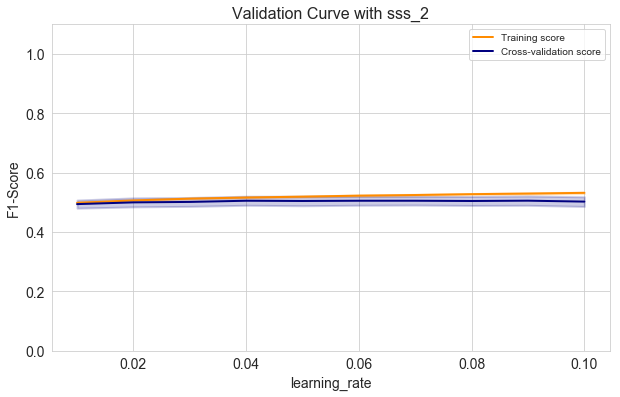

In [200]:
params = {
    # logistic regression for binary classification, output probability
    'objective': 'binary:logistic',
    # the depth of each tree
    'max_depth': 3,
    # usually 0.1~0.01
    #'learning_rate': 0.1,
    # 1 means silent mode, 0 is printing running messages
    'silent': 1,   
    # number of trees to fit
    'n_estimators': 500,
    # early stop, prevent overfitting, stops the training when the performance doesn't improve after this rounds.
    'early_stopping_rounds': 30,
    # ratio of data(rows) used in the model
    'subsample': 0.5,
    # ratio of parameters (columns) used for each tree
    'colsample_bytree': 0.8,
    # regularization paramter, usually 0,1,5
    'gamma': 3,
    # Balancing of positive and negative weights
    'scale_pos_weight': 4
}
# use two metrics; auc is the area under curve(roc curve)
params['eval_metric'] = ['auc']
sss_2 = XGBClassifier(**params)
param_range=np.arange(0.01, 0.11, 0.01)
train_scores, test_scores = validation_curve(
    sss_2, X_train, y_train, param_name="learning_rate", param_range=param_range,
    cv=10, scoring="f1", n_jobs=-1)


# Plot the validation curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize = (10,6))
plt.title("Validation Curve with sss_2", fontsize=16)
plt.xlabel("learning_rate", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()

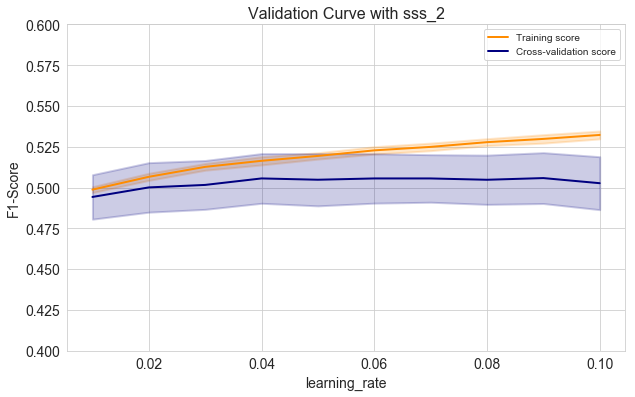

In [201]:
plt.figure(figsize = (10,6))
plt.title("Validation Curve with sss_2", fontsize=16)
plt.xlabel("learning_rate", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)
plt.ylim(0.4, 0.6)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()

Not much difference, but usually the `learning_rate` need to be set with the `n_estimators` together. So next step to set the `n_estimators` and temporarily set the `learning_rate` to be 0.04.

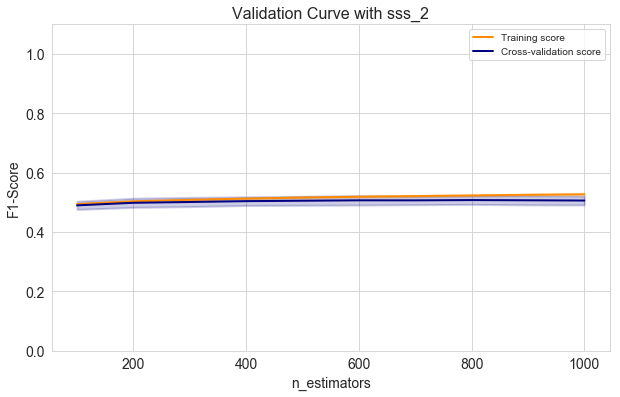

In [197]:
params = {
    # logistic regression for binary classification, output probability
    'objective': 'binary:logistic',
    # the depth of each tree
    'max_depth': 3,
    # usually 0.1~0.01
    'learning_rate': 0.04,
    # 1 means silent mode, 0 is printing running messages
    'silent': 1,   
    # number of trees to fit
    #'n_estimators': 500,
    # early stop, prevent overfitting, stops the training when the performance doesn't improve after this rounds.
    #'early_stopping_rounds': 50,
    # ratio of data(rows) used in the model
    'subsample': 0.5,
    # ratio of parameters (columns) used for each tree
    'colsample_bytree': 0.8,
    # regularization paramter, usually 0,1,5
    'gamma': 3,
    # Balancing of positive and negative weights
    'scale_pos_weight': 4
}
# use two metrics; auc is the area under curve(roc curve)
params['eval_metric'] = ['auc']
sss_2 = XGBClassifier(**params)
param_range=np.arange(100, 1001, 100)
train_scores, test_scores = validation_curve(
    sss_2, X_train, y_train, param_name="n_estimators", param_range=param_range,
    cv=10, scoring="f1", n_jobs=-1)


# Plot the validation curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize = (10,6))
plt.title("Validation Curve with sss_2", fontsize=16)
plt.xlabel("n_estimators", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()

Be more specific.

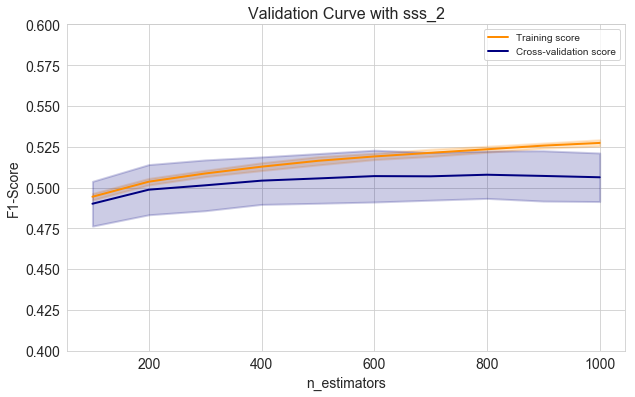

In [198]:
plt.figure(figsize = (10,6))
plt.title("Validation Curve with sss_2", fontsize=16)
plt.xlabel("n_estimators", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)
plt.ylim(0.4, 0.6)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()

We will choose `n_estimators` as 600 with `learning_rate` is 0.04.

Try one more group of `n_estimators` and `learning_rate`, the `learning_rate` is set to be 0.02. This is to whether finer learning rate with more estimators would give the better result.

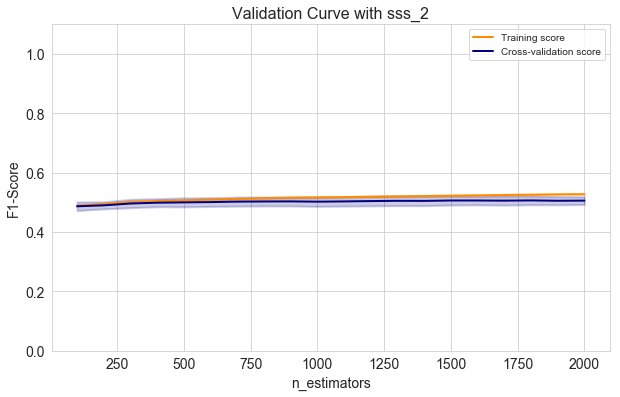

In [202]:
params = {
    # logistic regression for binary classification, output probability
    'objective': 'binary:logistic',
    # the depth of each tree
    'max_depth': 3,
    # usually 0.1~0.01
    'learning_rate': 0.02,
    # 1 means silent mode, 0 is printing running messages
    'silent': 1,   
    # number of trees to fit
    #'n_estimators': 500,
    # early stop, prevent overfitting, stops the training when the performance doesn't improve after this rounds.
    #'early_stopping_rounds': 50,
    # ratio of data(rows) used in the model
    'subsample': 0.5,
    # ratio of parameters (columns) used for each tree
    'colsample_bytree': 0.8,
    # regularization paramter, usually 0,1,5
    'gamma': 3,
    # Balancing of positive and negative weights
    'scale_pos_weight': 4
}
# use two metrics; auc is the area under curve(roc curve)
params['eval_metric'] = ['auc']
sss_2 = XGBClassifier(**params)
param_range=np.arange(100, 2001, 100)
train_scores, test_scores = validation_curve(
    sss_2, X_train, y_train, param_name="n_estimators", param_range=param_range,
    cv=10, scoring="f1", n_jobs=-1)


# Plot the validation curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize = (10,6))
plt.title("Validation Curve with sss_2", fontsize=16)
plt.xlabel("n_estimators", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()

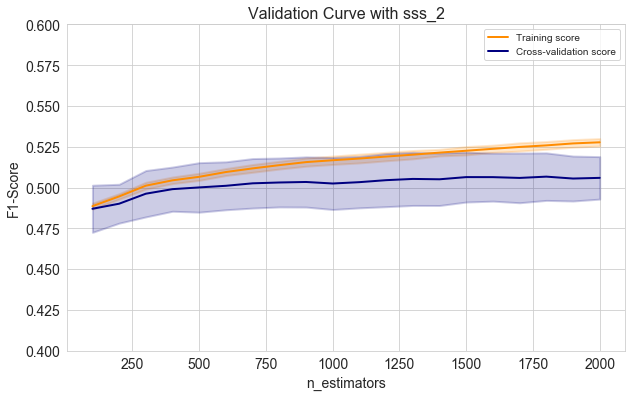

In [204]:
plt.figure(figsize = (10,6))
plt.title("Validation Curve with sss_2", fontsize=16)
plt.xlabel("n_estimators", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)
plt.ylim(0.4, 0.6)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()

It IS increasing, I am curious about if we set the n_estimators even larger?

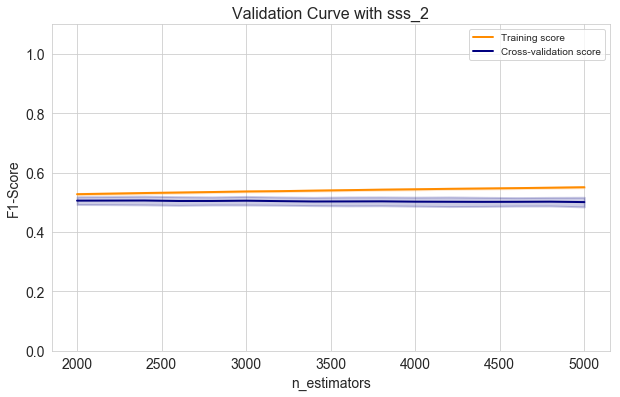

In [205]:
params = {
    # logistic regression for binary classification, output probability
    'objective': 'binary:logistic',
    # the depth of each tree
    'max_depth': 3,
    # usually 0.1~0.01
    'learning_rate': 0.02,
    # 1 means silent mode, 0 is printing running messages
    'silent': 1,   
    # number of trees to fit
    #'n_estimators': 500,
    # early stop, prevent overfitting, stops the training when the performance doesn't improve after this rounds.
    #'early_stopping_rounds': 50,
    # ratio of data(rows) used in the model
    'subsample': 0.5,
    # ratio of parameters (columns) used for each tree
    'colsample_bytree': 0.8,
    # regularization paramter, usually 0,1,5
    'gamma': 3,
    # Balancing of positive and negative weights
    'scale_pos_weight': 4
}
# use two metrics; auc is the area under curve(roc curve)
params['eval_metric'] = ['auc']
sss_2 = XGBClassifier(**params)
param_range=np.arange(2000, 5001, 200)
train_scores, test_scores = validation_curve(
    sss_2, X_train, y_train, param_name="n_estimators", param_range=param_range,
    cv=10, scoring="f1", n_jobs=-1)


# Plot the validation curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize = (10,6))
plt.title("Validation Curve with sss_2", fontsize=16)
plt.xlabel("n_estimators", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()

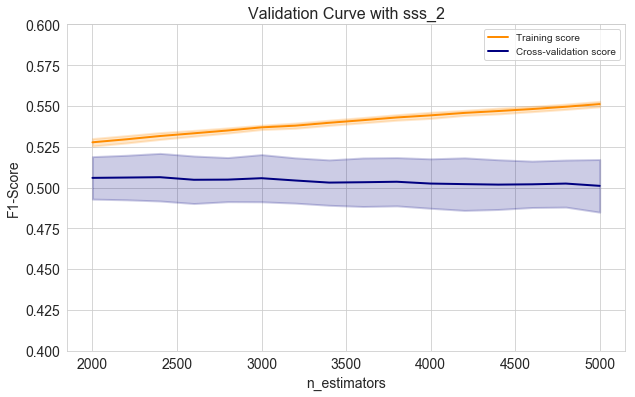

In [206]:
# Plot the validation curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize = (10,6))
plt.title("Validation Curve with sss_2", fontsize=16)
plt.xlabel("n_estimators", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)
plt.ylim(0.4, 0.6)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()

No, it's actually decreasing. We will still choose `n_estimators` as 600 with `learning_rate` is 0.04.

Parameter `subsample`

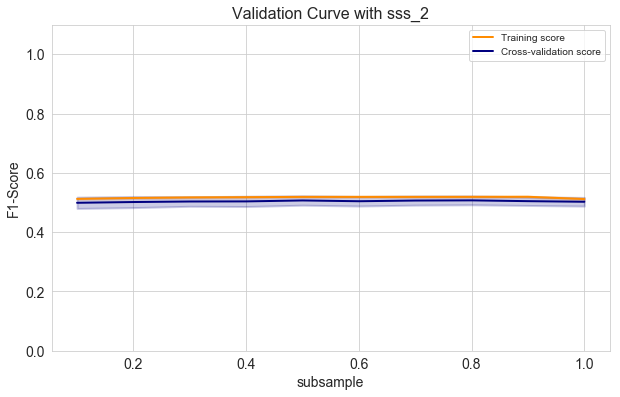

In [207]:
params = {
    # logistic regression for binary classification, output probability
    'objective': 'binary:logistic',
    # the depth of each tree
    'max_depth': 3,
    # usually 0.1~0.01
    'learning_rate': 0.04,
    # 1 means silent mode, 0 is printing running messages
    'silent': 1,   
    # number of trees to fit
    'n_estimators': 600,
    # early stop, prevent overfitting, stops the training when the performance doesn't improve after this rounds.
    #'early_stopping_rounds': 50,
    # ratio of data(rows) used in the model
    #'subsample': 0.5,
    # ratio of parameters (columns) used for each tree
    'colsample_bytree': 0.8,
    # regularization paramter, usually 0,1,5
    'gamma': 3,
    # Balancing of positive and negative weights
    'scale_pos_weight': 4
}
# use two metrics; auc is the area under curve(roc curve)
params['eval_metric'] = ['auc']
sss_2 = XGBClassifier(**params)
param_range=np.arange(0.1, 1.1, 0.1)
train_scores, test_scores = validation_curve(
    sss_2, X_train, y_train, param_name="subsample", param_range=param_range,
    cv=10, scoring="f1", n_jobs=-1)


# Plot the validation curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize = (10,6))
plt.title("Validation Curve with sss_2", fontsize=16)
plt.xlabel("subsample", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()

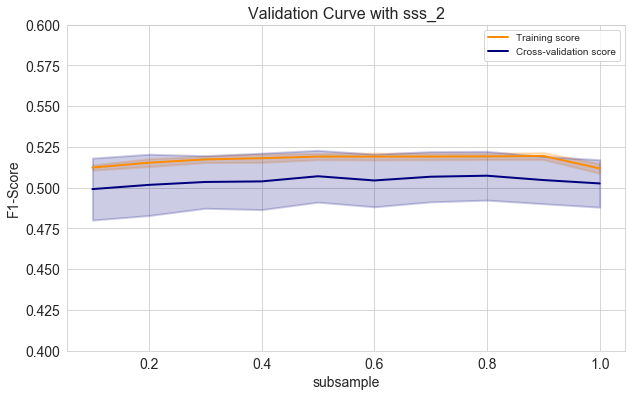

In [208]:
# Plot the validation curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize = (10,6))
plt.title("Validation Curve with sss_2", fontsize=16)
plt.xlabel("subsample", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)
plt.ylim(0.4, 0.6)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()

0.8 then.

paramenter `colsample_bytree`

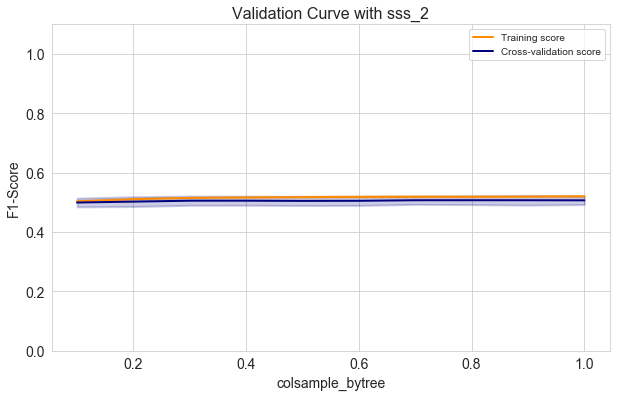

In [209]:
params = {
    # logistic regression for binary classification, output probability
    'objective': 'binary:logistic',
    # the depth of each tree
    'max_depth': 3,
    # usually 0.1~0.01
    'learning_rate': 0.04,
    # 1 means silent mode, 0 is printing running messages
    'silent': 1,   
    # number of trees to fit
    'n_estimators': 600,
    # early stop, prevent overfitting, stops the training when the performance doesn't improve after this rounds.
    #'early_stopping_rounds': 50,
    # ratio of data(rows) used in the model
    'subsample': 0.8,
    # ratio of parameters (columns) used for each tree
    #'colsample_bytree': 0.8,
    # regularization paramter, usually 0,1,5
    'gamma': 3,
    # Balancing of positive and negative weights
    'scale_pos_weight': 4
}
# use two metrics; auc is the area under curve(roc curve)
params['eval_metric'] = ['auc']
sss_2 = XGBClassifier(**params)
param_range=np.arange(0.1, 1.1, 0.1)
train_scores, test_scores = validation_curve(
    sss_2, X_train, y_train, param_name="colsample_bytree", param_range=param_range,
    cv=10, scoring="f1", n_jobs=-1)


# Plot the validation curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize = (10,6))
plt.title("Validation Curve with sss_2", fontsize=16)
plt.xlabel("colsample_bytree", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()

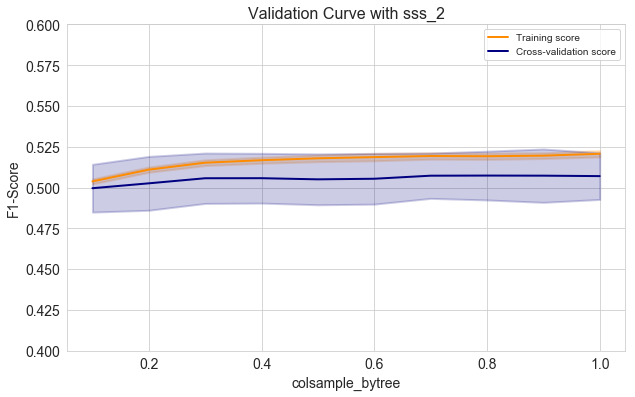

In [210]:
# Plot the validation curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize = (10,6))
plt.title("Validation Curve with sss_2", fontsize=16)
plt.xlabel("colsample_bytree", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)
plt.ylim(0.4, 0.6)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()

Parameter `gamma`

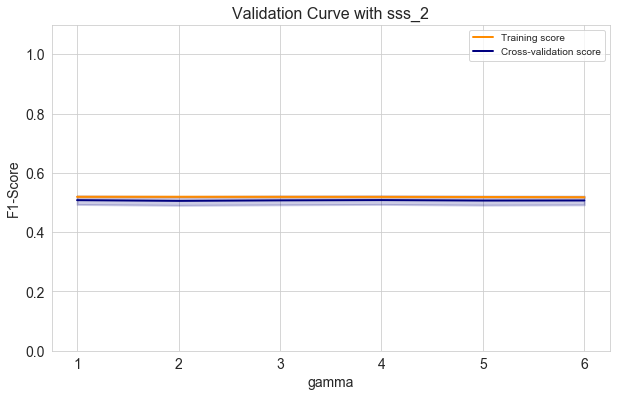

In [211]:
params = {
    # logistic regression for binary classification, output probability
    'objective': 'binary:logistic',
    # the depth of each tree
    'max_depth': 3,
    # usually 0.1~0.01
    'learning_rate': 0.04,
    # 1 means silent mode, 0 is printing running messages
    'silent': 1,   
    # number of trees to fit
    'n_estimators': 600,
    # early stop, prevent overfitting, stops the training when the performance doesn't improve after this rounds.
    #'early_stopping_rounds': 50,
    # ratio of data(rows) used in the model
    'subsample': 0.8,
    # ratio of parameters (columns) used for each tree
    'colsample_bytree': 0.8,
    # regularization paramter, usually 0,1,5
    #'gamma': 3,
    # Balancing of positive and negative weights
    'scale_pos_weight': 4
}
# use two metrics; auc is the area under curve(roc curve)
params['eval_metric'] = ['auc']
sss_2 = XGBClassifier(**params)
param_range=np.arange(1,7)
train_scores, test_scores = validation_curve(
    sss_2, X_train, y_train, param_name="gamma", param_range=param_range,
    cv=10, scoring="f1", n_jobs=-1)


# Plot the validation curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize = (10,6))
plt.title("Validation Curve with sss_2", fontsize=16)
plt.xlabel("gamma", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()

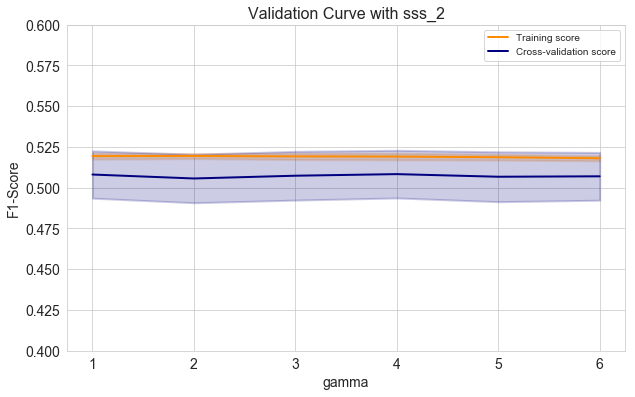

In [212]:
# Plot the validation curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize = (10,6))
plt.title("Validation Curve with sss_2", fontsize=16)
plt.xlabel("gamma", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)
plt.ylim(0.4, .6)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()

Set `gamma` to 4

Now set the final group of paramemters. And train the model

In [215]:
params = {
    # logistic regression for binary classification, output probability
    'objective': 'binary:logistic',
    # the depth of each tree
    'max_depth': 3,
    # usually 0.1~0.01
    'learning_rate': 0.04,
    # 1 means silent mode, 0 is printing running messages
    'silent': 1,   
    # number of trees to fit
    'n_estimators': 600,
    # early stop, prevent overfitting, stops the training when the performance doesn't improve after this rounds.
    #'early_stopping_rounds': 50,
    # ratio of data(rows) used in the model
    'subsample': 0.8,
    # ratio of parameters (columns) used for each tree
    'colsample_bytree': 0.8,
    # regularization paramter, usually 0,1,5
    'gamma': 4,
    # Balancing of positive and negative weights
    'scale_pos_weight': 4
}
# use two metrics; auc is the area under curve(roc curve)
params['eval_metric'] = ['auc']
theshold = 0.5
kf = KFold(n_splits = 10, shuffle=True)
cv_score = []
for train_index, test_index in kf.split(X_train):
    print("%s %s" % (train_index, test_index))
    X_in_train, X_in_vali = X_train[train_index], X_train[test_index]
    y_in_train, y_in_vali = y_train[train_index], y_train[test_index]
    
    dtrain = xgb.DMatrix(X_in_train, label=y_in_train) # weights added
    dvali = xgb.DMatrix(X_in_vali)
    bst_5 = xgb.train(params, dtrain, num_rounds)
    preds_binary = [1 if i>theshold else 0 for i in bst_5.predict(dvali)]
    cv_score.append(f1_score(preds_binary, y_in_vali))

[    0     1     2 ... 37066 37067 37068] [   19    28    43 ... 37052 37059 37062]
[    1     3     4 ... 37066 37067 37068] [    0     2    12 ... 37033 37038 37058]
[    0     1     2 ... 37064 37065 37067] [   16    17    36 ... 37025 37066 37068]
[    0     1     2 ... 37066 37067 37068] [   20    38    41 ... 37055 37060 37064]
[    0     1     2 ... 37066 37067 37068] [    3     8    10 ... 37045 37051 37061]
[    0     1     2 ... 37066 37067 37068] [    5    21    30 ... 37047 37056 37065]
[    0     1     2 ... 37066 37067 37068] [    7    18    49 ... 37011 37014 37044]
[    0     1     2 ... 37066 37067 37068] [    9    14    23 ... 37043 37048 37053]
[    0     1     2 ... 37065 37066 37068] [    4     6    25 ... 37039 37063 37067]
[    0     2     3 ... 37066 37067 37068] [    1    11    13 ... 37050 37054 37057]


In [216]:
np.mean(cv_score)

0.49035054509810044

The performance in the test dataset, when the threshold is set to 0.5.

In [233]:
dtest = xgb.DMatrix(X_test)
y_test_preds = (bst_5.predict(dtest) > 0.5).astype('int')
pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
0,3338,338,3676
1,191,252,443
All,3529,590,4119


In [234]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_test_preds)))

Accuracy: 0.87
Precision: 0.43
Recall: 0.57


If we want the type I error to be smaller, and the tolerance of type II error is larger, we can set the threshold lower.

In [239]:
dtest = xgb.DMatrix(X_test)
y_test_preds = (bst_5.predict(dtest) > 0.3).astype('int')
pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
0,2946,730,3676
1,131,312,443
All,3077,1042,4119


In [240]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_test_preds)))

Accuracy: 0.79
Precision: 0.30
Recall: 0.70


## Summary

Although the total accuracy is 87%, which is less than we set all the cases' label to 0, the recall is much more important in this project. 

In this project, the recall means how we identify those who are actually going to subscribe the deposit. The type I error is how we mislabel them. And the precision score means, among those identify as positive by our model, who are actually going to subscribe the deposit. So the tpye II error only cause the decision maker making more calls, but the type I error may lose money. As a result, the recall score should be the most important metrics in this project.

The final model improves the recall score from 28% to 57%, if we change the threshold, it can be even improved to 70%.